# Contextual info

https://filecoin.energy/methodology

https://filecoin-green.gitbook.io/filecoin-green-documentation/filecoin-green-api-docs/list-of-apis/energy-consumption-api

https://www.investopedia.com/terms/r/rec.asp

Electrical Power = ( A • (Sealing Rate) + B • (Raw Capacity) ) • PUE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib import dates
import math

import datetime
from datetime import timezone

In [2]:
# fit a linear model (Open sourced Facebook's Prophet model: https://facebook.github.io/prophet/)
# As the data is subdaily, the model will fit daily seasonality
from prophet import Prophet

from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

In [105]:
# statistics and econometrics

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

from scalecast.Forecaster import Forecaster

In [4]:
filusd = pd.read_csv("FIL-USD-FIL-USD.csv", parse_dates = ['Date'])
filusd

Date       Open       High        Low      Close  Adj Close  \
0    2017-12-13  11.474800  11.507300  11.018800  11.503200  11.503200   
1    2017-12-14  11.483200  11.804200  10.954300  11.481600  11.481600   
2    2017-12-15  11.480900  13.001400  11.152600  12.900500  12.900500   
3    2017-12-16  12.900500  21.955000  12.870500  20.495501  20.495501   
4    2017-12-17  20.502399  20.502399  17.840700  19.435400  19.435400   
...         ...        ...        ...        ...        ...        ...   
1796 2022-11-13   4.268186   4.429925   4.222209   4.293976   4.293976   
1797 2022-11-14   4.294374   4.389970   4.106500   4.316591   4.316591   
1798 2022-11-15   4.316776   4.491105   4.292059   4.389140   4.389140   
1799 2022-11-16   4.388834   4.534030   4.274555   4.337914   4.337914   
1800 2022-11-17   4.334792   4.383778   4.262553   4.285855   4.285855   

         Volume  
0        296217  
1        391397  
2        653202  
3       2137330  
4        624487  
...         ...  
1796  119578514  
1797  161268566  
1798  114251131  
1799  147278408  
1800  130081440  

[1801 rows x 7 columns]

In [5]:
consumption = pd.read_csv("FilecoinGreenEnergyConsumption-FilecoinGreenEnergyConsumption.csv", 
                          parse_dates = ['Date'])


In [6]:
consumption['PUE'] = consumption['Energy consumption rate estimate'] / ((consumption['Energy used to seal data estimate'] + consumption['Energy used to store data estimate']))

In [7]:
consumption.iloc[500:1550]

Date  Data storage capacity  \
500 2022-01-06 00:00:00+00:00            16361591046   
501 2022-01-07 00:00:00+00:00            16386977153   
502 2022-01-08 00:00:00+00:00            16412056555   
503 2022-01-09 00:00:00+00:00            16436755007   
504 2022-01-10 00:00:00+00:00            16462546801   
..                        ...                    ...   
779 2022-10-12 00:00:00+00:00            22656642177   
780 2022-10-13 00:00:00+00:00            22669204228   
781 2022-10-14 00:00:00+00:00            22681425707   
782 2022-10-15 00:00:00+00:00            22694012962   
783 2022-10-16 00:00:00+00:00            22703885332   

     Data storage capacity added per day  \
500                             24835648   
501                             25408256   
502                             24772992   
503                             25235776   
504                             25761216   
..                                   ...   
779                             11987424   
780                             12611296   
781                             12329664   
782                             12360032   
783                              7650816   

     Cumulative renewable energy purchases  Energy intensity lower bound  \
500                           1.357694e+09                      1.744488   
501                           1.358026e+09                      1.755588   
502                           1.358358e+09                      1.741598   
503                           1.358690e+09                      1.750415   
504                           1.359022e+09                      1.760467   
..                                     ...                           ...   
779                           1.452033e+09                      1.407692   
780                           1.452033e+09                      1.416966   
781                           1.452033e+09                      1.412635   
782                           1.452033e+09                      1.412988   
783                           1.452033e+09                      1.342260   

     Energy intensity estimate  Energy intensity upper bound  \
500                   9.341385                     25.904656   
501                   9.425361                     26.073870   
502                   9.319521                     25.860601   
503                   9.386224                     25.995008   
504                   9.462266                     26.148234   
..                         ...                           ...   
779                   6.793503                     20.770641   
780                   6.863659                     20.912006   
781                   6.830892                     20.845981   
782                   6.833563                     20.851364   
783                   6.298506                     19.773216   

     Energy consumption rate lower bound  Energy consumption rate estimate  \
500                          26582.36539                       142343.2650   
501                          26793.02200                       143845.7359   
502                          26620.18180                       142448.1279   
503                          26795.21528                       143683.5768   
504                          26991.37360                       145074.9105   
..                                   ...                               ...   
779                          29703.21283                       143347.2702   
780                          29915.47050                       144907.9044   
781                          29840.10609                       144293.8801   
782                          29864.12860                       144430.4115   
783                          28381.61543                       133179.6431   

     Energy consumption rate upper bound  \
500                          394733.0537   
501                          397927.9809   
502                          395277.1889   
503                         

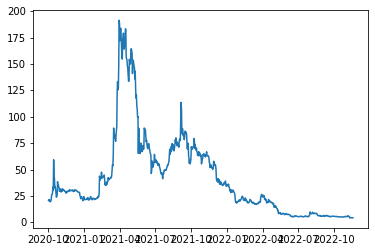

In [8]:
filtered = filusd[filusd['Date'] > '2020-10-01']

plt.plot(filtered['Date'], filtered['Close'])

In [9]:
# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python?scriptVersionId=50985180&cellId=80
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

# Analyze the energy performance and the evolution of Filecoin's storage (10 pts)

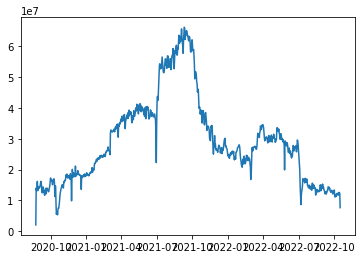

In [10]:
plt.plot(consumption['Date'], consumption['Data storage capacity added per day'])

In [11]:
e_intensity_df = consumption[['Date','Energy intensity lower bound','Energy intensity estimate','Energy intensity upper bound']]

In [12]:
e_intensity_df.head(20)

Date  Energy intensity lower bound  \
0  2020-08-24 00:00:00+00:00                   1404.098113   
1  2020-08-25 00:00:00+00:00                    516.832219   
2  2020-08-26 00:00:00+00:00                    200.762976   
3  2020-08-27 00:00:00+00:00                    134.966149   
4  2020-08-28 00:00:00+00:00                    108.350558   
5  2020-08-29 00:00:00+00:00                     68.492172   
6  2020-08-30 00:00:00+00:00                     60.347890   
7  2020-08-31 00:00:00+00:00                     53.463617   
8  2020-09-01 00:00:00+00:00                     45.213011   
9  2020-09-02 00:00:00+00:00                     40.084598   
10 2020-09-03 00:00:00+00:00                     36.980768   
11 2020-09-04 00:00:00+00:00                     34.270226   
12 2020-09-05 00:00:00+00:00                     32.915146   
13 2020-09-06 00:00:00+00:00                     31.625354   
14 2020-09-07 00:00:00+00:00                     28.808854   
15 2020-09-08 00:00:00+00:00                     23.950915   
16 2020-09-09 00:00:00+00:00                     20.038685   
17 2020-09-10 00:00:00+00:00                     19.177170   
18 2020-09-11 00:00:00+00:00                     20.187288   
19 2020-09-12 00:00:00+00:00                     19.645366   

    Energy intensity estimate  Energy intensity upper bound  
0                10618.245610                  21402.982540  
1                 3906.016457                   7877.754829  
2                 1514.930303                   3059.685608  
3                 1017.172660                   2056.697582  
4                  815.823835                   1650.977121  
5                  514.292326                   1043.387269  
6                  452.680264                    919.238176  
7                  400.600251                    814.296282  
8                  338.183832                    688.526399  
9                  299.387022                    610.350331  
10                 275.906331                    563.036436  
11                 255.400890                    521.717710  
12                 245.149612                    501.061254  
13                 235.392246                    481.400037  
14                 214.085225                    438.466116  
15                 177.334575                    364.413085  
16                 147.738275                    304.776162  
17                 141.220856                    291.643480  
18                 148.862469                    307.041428  
19                 144.762792                    298.780526

In [13]:
start = -500
end = -1

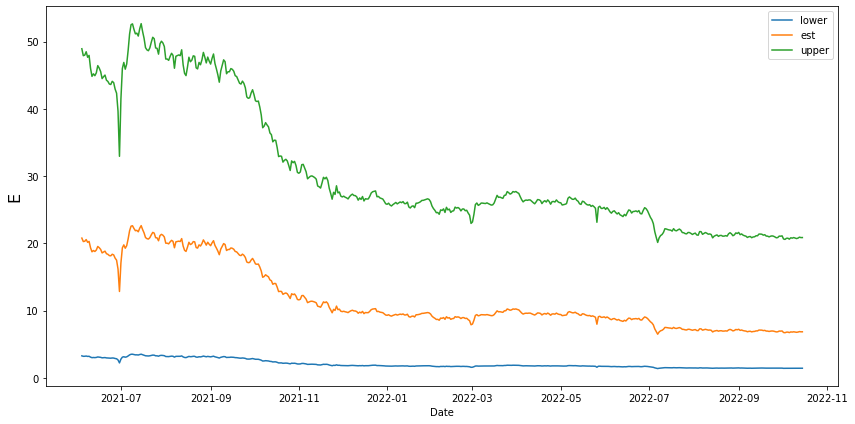

In [14]:

sub_df = consumption.iloc[start:end]
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=sub_df, x="Date", y="Energy intensity lower bound", label = 'lower', ax=ax)
sns.lineplot(data=sub_df, x="Date", y="Energy intensity estimate", label = 'est', ax=ax)
sns.lineplot(data=sub_df, x="Date", y="Energy intensity upper bound", label = 'upper', ax=ax)

plt.ylabel('E', fontsize=16)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
# ax.xaxis.set_major_formatter(dates.DateFormatter("%d-%b"))

ax.legend()
plt.tight_layout()
plt.show()

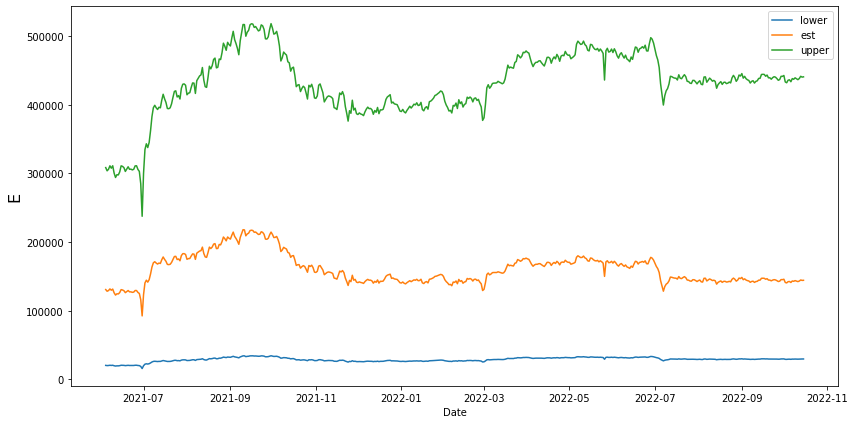

In [15]:
sub_df = consumption.iloc[start:end]
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=sub_df, x="Date", y="Energy consumption rate lower bound", label = 'lower', ax=ax)
sns.lineplot(data=sub_df, x="Date", y="Energy consumption rate estimate", label = 'est', ax=ax)
sns.lineplot(data=sub_df, x="Date", y="Energy consumption rate upper bound", label = 'upper', ax=ax)

plt.ylabel('E', fontsize=16)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
# ax.xaxis.set_major_formatter(dates.DateFormatter("%d-%b"))

ax.legend()
plt.tight_layout()
plt.show()

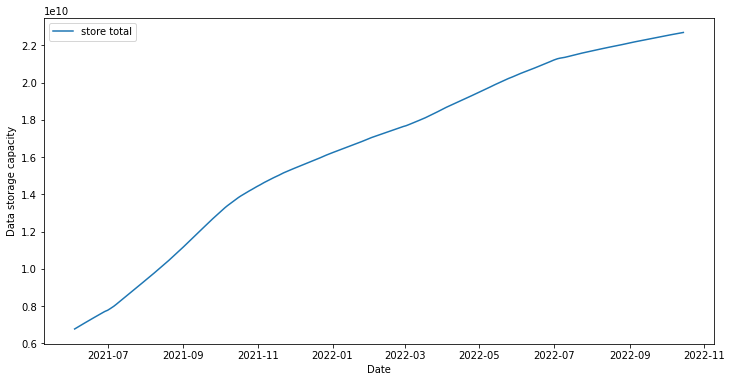

In [16]:

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=sub_df, x="Date", y='Data storage capacity', label = 'store total', ax=ax)

plt.show()

<AxesSubplot: xlabel='Date', ylabel='Data storage capacity added per day'>

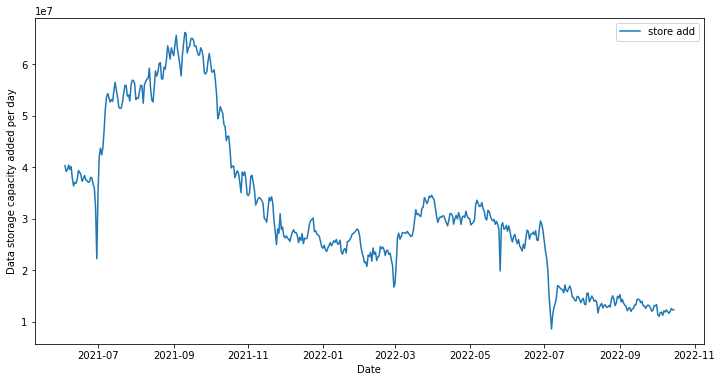

In [17]:
mpatches
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=sub_df, x="Date", y='Data storage capacity added per day', label = 'store add', ax=ax)

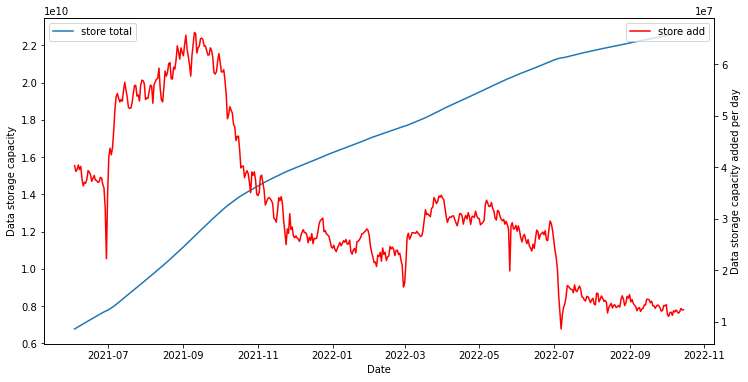

In [18]:

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=sub_df, x="Date", y='Data storage capacity', label = 'store total', ax=ax)
ax2 = ax.twinx()

sns.lineplot(data=sub_df, x="Date", y='Data storage capacity added per day', label = 'store add', ax=ax2, color="r")
plt.show()

## Generally speaking as storage added increases, energy intensity decreases.

This may mean that newer storage added is more energy efficient or previously added storage became less energy intensive.

As shown by the graph with both storage added and total storage, the initial first few days with the stark decrease in energy intensity has storage added that's nearly of the same degree as total storage, thus it's the newly added storage daily is siginificant relative to existing storage, and if they are more energy efficienct, it explains the sudden dip in the first few days of these datasets.

In terms of correlations of types of data, Data storage capacity added per day is positive correlated to energy intensity (at least for the last few dates)

# Analyze the evolution of the share of renewable energy used by Filecoin (10 pts)

For the provided dataset, Cumulative renewable energy certificate (REC) purchases over time is the best indicator of renewable energy use.

The more energy used, the more likely a data provider would purchase an REC to offset environmental costs of data provision.

Since we see a decrease in energy intensity overtime, we expect rate of REC purchases to decrease overtime. 

<!-- Given the green initiatives Filecoin has been embarking on such as carbon offsetting, we are expecting an increase in that value, and an increasing increase in the later half of 2022 -->

In [19]:
start = -500
end = -1
sub_df = consumption.iloc[start:end]

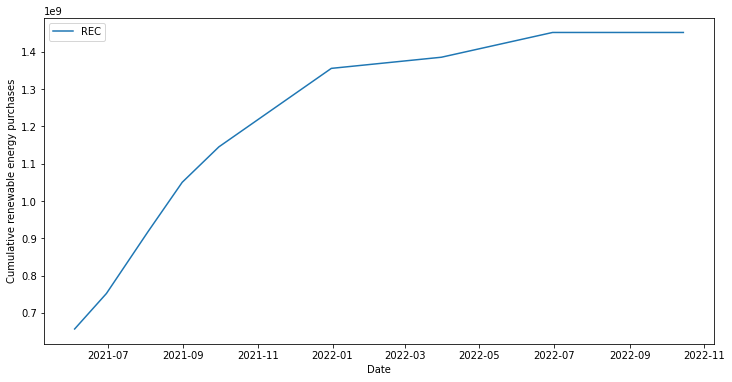

In [20]:

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=sub_df, x="Date", y="Cumulative renewable energy purchases", label = 'REC', ax=ax)
plt.show()

It increases at a decreasing rate from 2021 jan till 2022 oct. Thus helping to corroborate that newly added storages are more energy efficient, requiring less electricity per unit storage and thus requireing less REC offsets and lower purchases of RECs

# HOWEVER

Let's instead investigate the actual share of renewable energy used by FIL, taking cumulative REC energies and comparing it against total Cumulative energy use estimate bound 

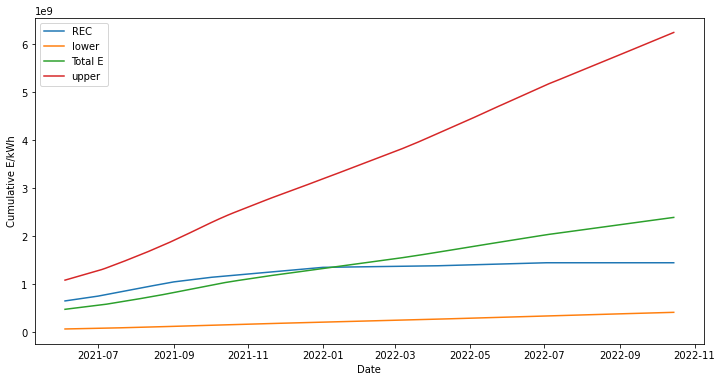

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=sub_df, x="Date", y="Cumulative renewable energy purchases", label = 'REC', ax=ax)
sns.lineplot(data=sub_df, x="Date", y="Cumulative energy use lower bound", label = 'lower', ax=ax)
sns.lineplot(data=sub_df, x="Date", y="Cumulative energy use estimate", label = 'Total E', ax=ax)
sns.lineplot(data=sub_df, x="Date", y="Cumulative energy use upper bound", label = 'upper', ax=ax)
plt.ylabel('Cumulative E/kWh')
plt.show()

In [22]:
sub_df["REC_TO_TOTAL"] = sub_df["Cumulative renewable energy purchases"] / sub_df["Cumulative energy use upper bound"]

/tmp/ipykernel_15786/3821640422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["REC_TO_TOTAL"] = sub_df["Cumulative renewable energy purchases"] / sub_df["Cumulative energy use upper bound"]


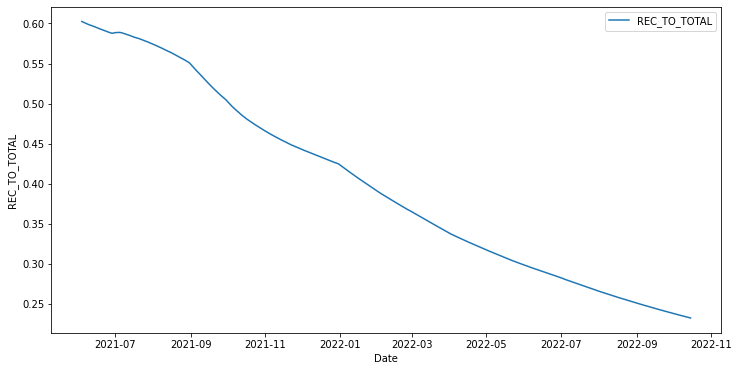

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=sub_df, x="Date", y="REC_TO_TOTAL", label = 'REC_TO_TOTAL', ax=ax)
plt.show()

## The above plot shows cumulative purchases of REC wrt cumulative energy consumption decreases over time.

This could indicate that perhaps data providers are increasingly more energy efficient, that they see decreasing need to offset their carbon emissions via purchasing RECs. This is partially corroborated by studies showing growth in cloud usage, and these cloud data storage providers are adopting more energy efficienct practices, making it more energy efficient for enterprises to store data on cloud than on premise.

This could also hint at more decentralised data provision. RECs are instruments typically used by large companies that may have to comply with strict emission goals ( country dependent ), however individuals are not as stringently required to comply, thus indicating more smaller data provisioners ( see if external data can validate this )

# Correlation (20 points)

### Check if there's other correlation equations?

In [24]:
filusd.head()

Date       Open       High      Low      Close  Adj Close   Volume
0 2017-12-13  11.474800  11.507300  11.0188  11.503200  11.503200   296217
1 2017-12-14  11.483200  11.804200  10.9543  11.481600  11.481600   391397
2 2017-12-15  11.480900  13.001400  11.1526  12.900500  12.900500   653202
3 2017-12-16  12.900500  21.955000  12.8705  20.495501  20.495501  2137330
4 2017-12-17  20.502399  20.502399  17.8407  19.435400  19.435400   624487

In [76]:
joined_df = filusd[['Date','Close']]
joined_df['Date'] = pd.to_datetime(joined_df['Date'], utc = True)
joined_df = pd.merge(joined_df, consumption[['Date','Energy used to seal data estimate','Data storage capacity added per day','Energy consumption rate estimate']],  on='Date')
# joined_df = joined_df.rename(columns={"Date_x": "Date"})
joined_df = joined_df.set_index('Date')

/tmp/ipykernel_15786/3584886060.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joined_df['Date'] = pd.to_datetime(joined_df['Date'], utc = True)


In [26]:
joined_df.head()

Close  Energy used to seal data estimate  \
Date                                                                      
2020-08-24 00:00:00+00:00  22.020189                        3137.985593   
2020-08-25 00:00:00+00:00  22.193523                       21374.515770   
2020-08-26 00:00:00+00:00  21.462585                       20195.466240   
2020-08-27 00:00:00+00:00  22.159378                       21822.785450   
2020-08-28 00:00:00+00:00  24.273489                       24722.329720   

                           Data storage capacity added per day  \
Date                                                             
2020-08-24 00:00:00+00:00                              2053024   
2020-08-25 00:00:00+00:00                             13984256   
2020-08-26 00:00:00+00:00                             13212864   
2020-08-27 00:00:00+00:00                             14277536   
2020-08-28 00:00:00+00:00                             16174560   

                           Energy consumption rate estimate  
Date                                                         
2020-08-24 00:00:00+00:00                       4929.158175  
2020-08-25 00:00:00+00:00                      33604.707650  
2020-08-26 00:00:00+00:00                      31820.943110  
2020-08-27 00:00:00+00:00                      34445.662720  
2020-08-28 00:00:00+00:00                      39074.139640

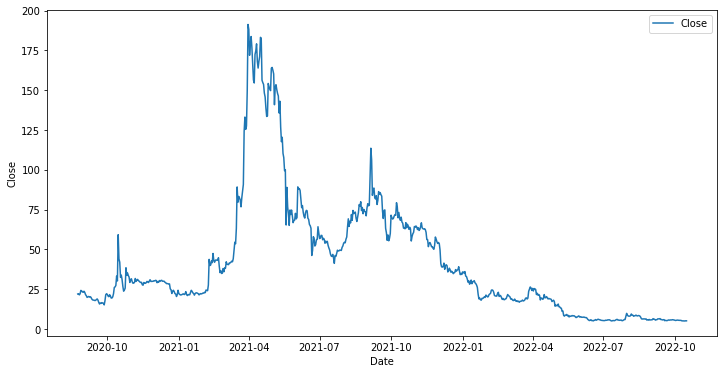

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=joined_df, x="Date", y="Close", label = 'Close', ax=ax)
plt.show()

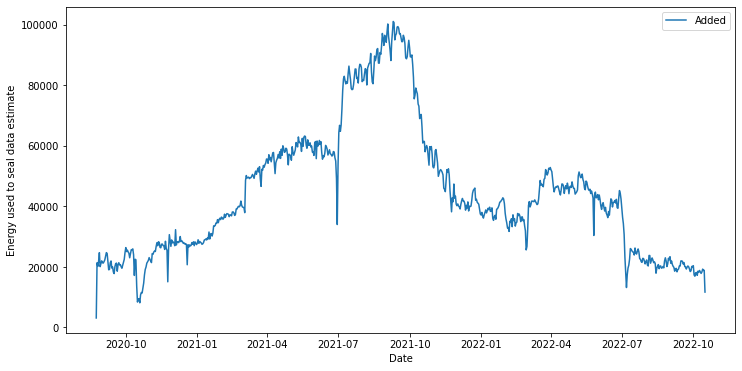

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=joined_df, x="Date", y="Energy used to seal data estimate", label = 'Added', ax=ax)
plt.show()

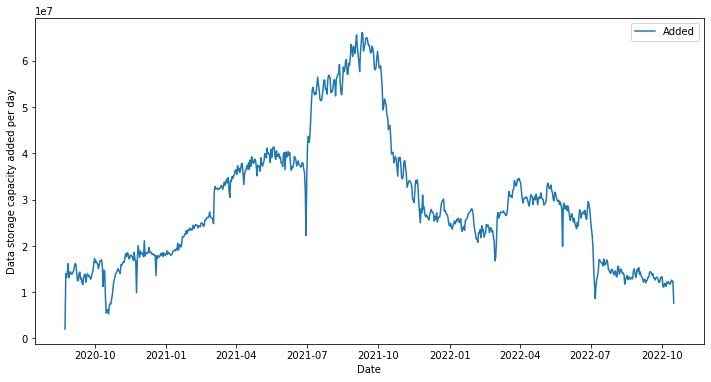

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=joined_df, x="Date", y="Data storage capacity added per day", label = 'Added', ax=ax)
plt.show()

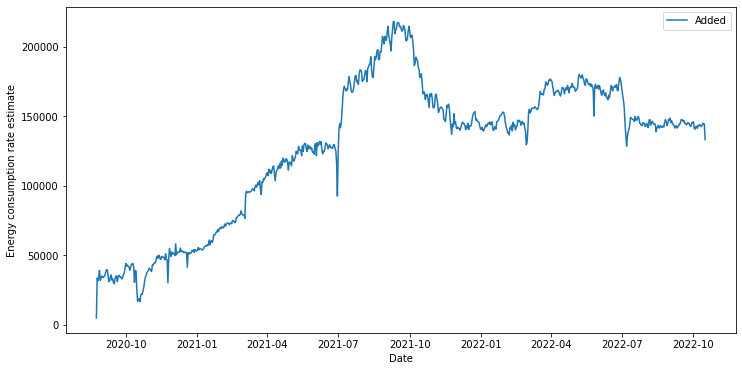

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=joined_df, x="Date", y="Energy consumption rate estimate", label = 'Added', ax=ax)
plt.show()

## Visually, there seems to be similar patterns if we account for month-wise lagging, which we shall implement 

In [75]:
# TRying different months
# for i in range(1,6):
#     joined_df[f'Seal Energy shift_b_{i}m'] = joined_df['Energy used to seal data estimate'].shift(-i * 31)
# joined_df[f'Seal Energy shift_b_{3.5}m'] = joined_df['Energy used to seal data estimate'].shift(math.floor(-3.5 * 31))

In [77]:
close_col = "Close"
for i in range(1,6):
    joined_df[f'{close_col}_shift_b_{i}m'] = joined_df[close_col].shift(-i * 31)

In [65]:
df_z_scaled = joined_df.copy()
for column in df_z_scaled.columns:
    df_z_scaled[column] = (df_z_scaled[column] -
                           df_z_scaled[column].mean()) / df_z_scaled[column].std()   

In [34]:
df_z_scaled.head()

Close  Energy used to seal data estimate  \
Date                                                                     
2020-08-24 00:00:00+00:00 -0.513257                          -1.928079   
2020-08-25 00:00:00+00:00 -0.508717                          -1.073244   
2020-08-26 00:00:00+00:00 -0.527862                          -1.128511   
2020-08-27 00:00:00+00:00 -0.509611                          -1.052231   
2020-08-28 00:00:00+00:00 -0.454235                          -0.916315   

                           Data storage capacity added per day  \
Date                                                             
2020-08-24 00:00:00+00:00                            -1.928079   
2020-08-25 00:00:00+00:00                            -1.073244   
2020-08-26 00:00:00+00:00                            -1.128511   
2020-08-27 00:00:00+00:00                            -1.052231   
2020-08-28 00:00:00+00:00                            -0.916315   

                           Energy consumption rate estimate  \
Date                                                          
2020-08-24 00:00:00+00:00                         -2.419303   
2020-08-25 00:00:00+00:00                         -1.853523   
2020-08-26 00:00:00+00:00                         -1.888717   
2020-08-27 00:00:00+00:00                         -1.836931   
2020-08-28 00:00:00+00:00                         -1.745609   

                           Data Stored shift_b_1m  Data Stored shift_b_2m  \
Date                                                                        
2020-08-24 00:00:00+00:00               -1.154753               -1.387147   
2020-08-25 00:00:00+00:00               -1.187873               -1.301330   
2020-08-26 00:00:00+00:00               -1.211655               -1.263834   
2020-08-27 00:00:00+00:00               -1.162704               -1.202213   
2020-08-28 00:00:00+00:00               -1.119377               -1.179749   

                           Data Stored shift_b_3m  Data Stored shift_b_4m  \
Date                                                                        
2020-08-24 00:00:00+00:00               -1.027292               -0.996660   
2020-08-25 00:00:00+00:00               -0.801364               -0.957632   
2020-08-26 00:00:00+00:00               -0.898430               -1.019249   
2020-08-27 00:00:00+00:00               -0.987427               -0.958483   
2020-08-28 00:00:00+00:00               -0.885172               -0.980291   

                           Data Stored shift_b_5m  Data Stored shift_b_3.5m  
Date                                                                         
2020-08-24 00:00:00+00:00               -0.705309                 -0.932744  
2020-08-25 00:00:00+00:00               -0.648383                 -0.918648  
2020-08-26 00:00:00+00:00               -0.696399                 -0.935118  
2020-08-27 00:00:00+00:00               -0.647309                 -0.960262  
2020-08-28 00:00:00+00:00               -0.625497                 -0.952529

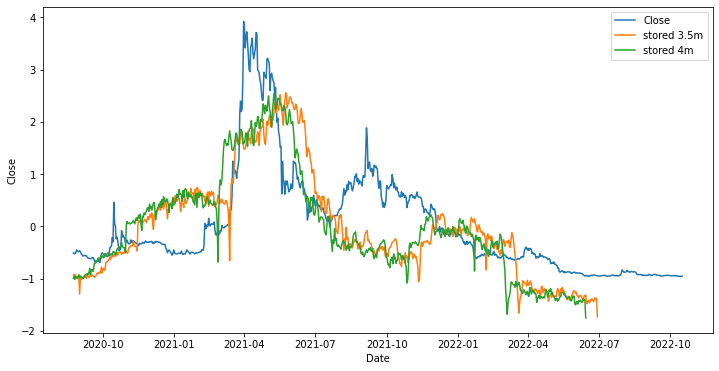

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=df_z_scaled, x="Date", y="Close", label = 'Close', ax=ax)
sns.lineplot(data=df_z_scaled, x="Date", y="Data Stored shift_b_3.5m", label = 'stored 3.5m', ax=ax)
sns.lineplot(data=df_z_scaled, x="Date", y="Data Stored shift_b_4m", label = 'stored 4m', ax=ax)
plt.show()

In [79]:
start = -10000
end = -1
sample_df = joined_df.iloc[start:end]

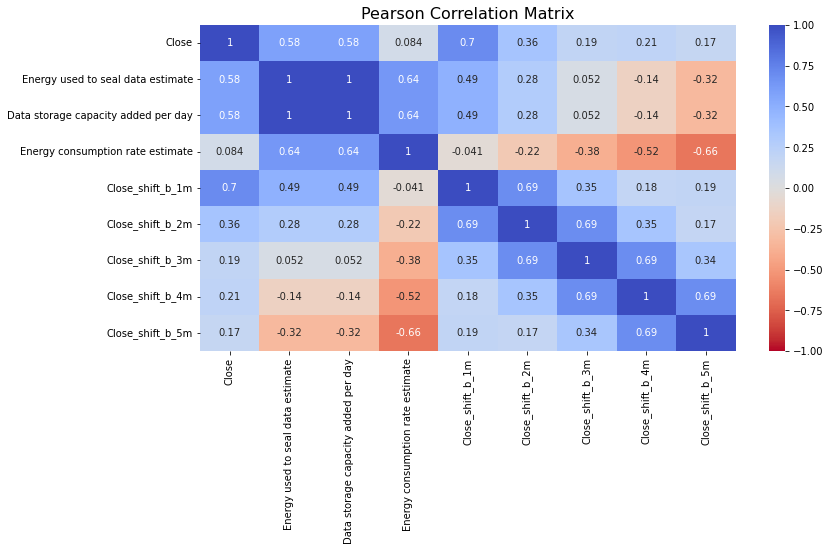

In [80]:
fig, ax = plt.subplots(figsize=(12, 6))
corrmat = sample_df.corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax)
# ax.set_title('Correlation Matrix of Close price and seal energy', fontsize=16)
ax.set_title('Pearson Correlation Matrix', fontsize=16)
plt.show()

In [40]:
# fig, ax = plt.subplots(figsize=(12, 6))
# df_z_scaled = sample_df.copy()
# for column in df_z_scaled.columns:
#     df_z_scaled[column] = (df_z_scaled[column] -
#                            df_z_scaled[column].mean()) / df_z_scaled[column].std()    
# corrmat = df_z_scaled.corr()

# sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax)
# # ax.set_title('Correlation Matrix of Close price and seal energy', fontsize=16)
# ax.set_title('Spearman Correlation Matrix (not normalised)', fontsize=16)
# plt.show()

## Insights

Energy used to seal data estimate and data storage capacity are perfectly correlated (makes sense because these 2 values are by definition directly proportionate

Energy used to seal data and data storage capacity added daily are strongly correlated to closing price of FIL coin, and almost perfectly not correlated to energy conusmed 

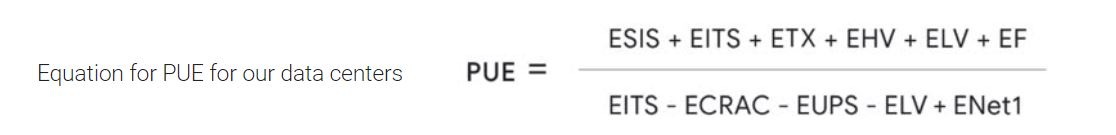

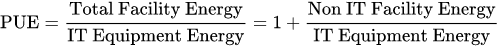

most compute instances have migrated to large cloud- and hyperscale-class data centers, which utilize ultra-efficient cooling systems

# Algorithm (35 points):

Build an algorithm to predict the storage capacity added per day for the month of December  2022 (You can use any datasets to help you as long as you publish them on Ocean Market).

Expansion:

This is pretty open-ended. Ideal scenario is predicting the storage capacity added per day for the whole month at once (1-31 Dec) or for the remaining of December. This may be possible if there's some monthly trend we're able to retrieve.

Alternatives include predicting weekly based on past weeks stats, or a day before prediction.



### Insights
1. 

### Refs

https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/151927

### Approaches:

#### Generic

https://machinelearningmastery.com/multi-step-time-series-forecasting/


#### Specific
1. Univariate on data store added 
2. Multivariate, including close prices and others
3. LightGBM
4. LSTM

### Other explanations:

Q: Why are there major increases in data storage added in July 2021 and Mar 2022?

A: Prices were being pumped in these two periods, which tally with advancements in the Filecoin ecosystem based on good news found from popular media sites like cointelegraph. During these price pumps, there may be a sudden boost in incentive to mine filecoin, thus this boost in data storage added as well. One of these advancements is  committing to sustainability via trasparency in energy usage. Such indicate very siginicant milestones to FIL and resonate with investors/ppl in the crypto space. Other milestones such as the recennt Space Warp did coincide with a ~2.5% uptick in price, though it could also be attributed to swing trading

https://cointelegraph.com/news/filecoin-gains-40-in-48-hours-what-s-driving-the-massive-fil-price-rally

In [38]:
target_col = 'Data storage capacity added per day'

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


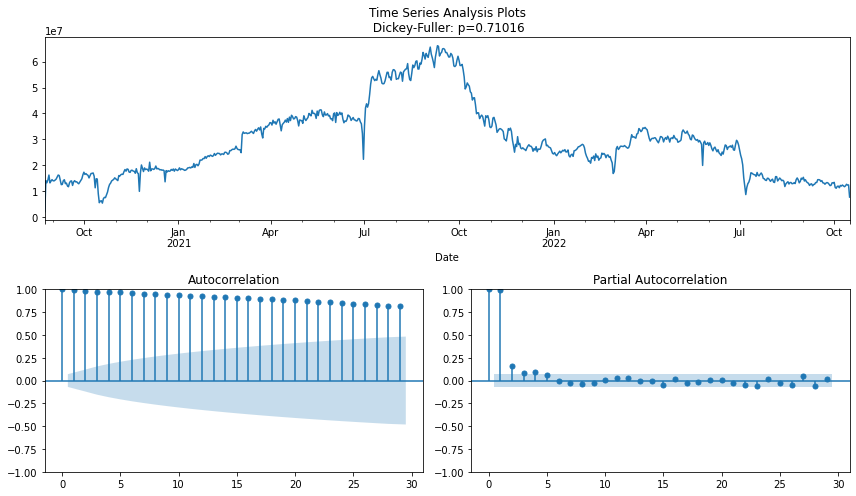

In [39]:
tsplot(joined_df[target_col])

In [40]:
#Since non stationary, try differencing
joined_df[f"{target_col}_diff_1"] = joined_df[target_col].diff(periods=1)
# joined_df[f"{target_col}_diff_2"] = joined_df[target_col].diff(periods=2)
# joined_df[f"{target_col}_diff_3"] = joined_df[target_col].diff(periods=3)


/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


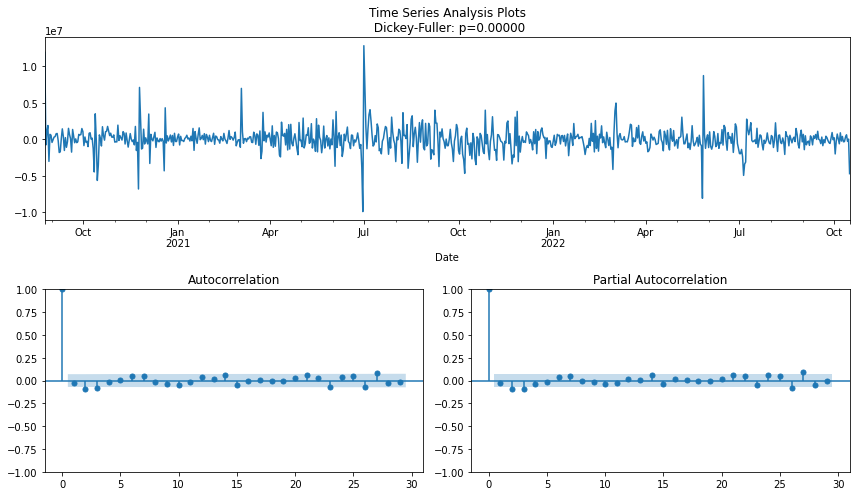

In [41]:
tsplot(joined_df[f"{target_col}_diff_1"].dropna())

In [100]:
joined_df.tail()

Close  Energy used to seal data estimate  \
Date                                                                     
2022-10-12 00:00:00+00:00  5.145176                        18322.41796   
2022-10-13 00:00:00+00:00  5.137164                        19275.98760   
2022-10-14 00:00:00+00:00  5.066583                        18845.52153   
2022-10-15 00:00:00+00:00  5.184858                        18891.93811   
2022-10-16 00:00:00+00:00  5.153086                        11694.04273   

                           Data storage capacity added per day  \
Date                                                             
2022-10-12 00:00:00+00:00                             11987424   
2022-10-13 00:00:00+00:00                             12611296   
2022-10-14 00:00:00+00:00                             12329664   
2022-10-15 00:00:00+00:00                             12360032   
2022-10-16 00:00:00+00:00                              7650816   

                           Energy consumption rate estimate  \
Date                                                          
2022-10-12 00:00:00+00:00                       143347.2702   
2022-10-13 00:00:00+00:00                       144907.9044   
2022-10-14 00:00:00+00:00                       144293.8801   
2022-10-15 00:00:00+00:00                       144430.4115   
2022-10-16 00:00:00+00:00                       133179.6431   

                           Data Stored shift_b_1m  Data Stored shift_b_2m  \
Date                                                                        
2022-10-12 00:00:00+00:00                     NaN                     NaN   
2022-10-13 00:00:00+00:00                     NaN                     NaN   
2022-10-14 00:00:00+00:00                     NaN                     NaN   
2022-10-15 00:00:00+00:00                     NaN                     NaN   
2022-10-16 00:00:00+00:00                     NaN                     NaN   

                           Data Stored shift_b_3m  Data Stored shift_b_4m  \
Date                                                                        
2022-10-12 00:00:00+00:00                     NaN                     NaN   
2022-10-13 00:00:00+00:00                     NaN                     NaN   
2022-10-14 00:00:00+00:00                     NaN                     NaN   
2022-10-15 00:00:00+00:00                     NaN                     NaN   
2022-10-16 00:00:00+00:00                     NaN                     NaN   

                           Data Stored shift_b_5m  Data Stored shift_b_3.5m  \
Date                                                                          
2022-10-12 00:00:00+00:00                     NaN                       NaN   
2022-10-13 00:00:00+00:00                     NaN                       NaN   
2022-10-14 00:00:00+00:00                     NaN                       NaN   
2022-10-15 00:00:00+00:00                     NaN                       NaN   
2022-10-16 00:00:00+00:00                     NaN                       NaN   

                           Data storage capacity added per day_diff_1  \
Date                                                                    
2022-10-12 00:00:00+00:00                                    308032.0   
2022-10-13 00:00:00+00:00                                    623872.0   
2022-10-14 00:00:00+00:00                                   -281632.0   
2022-10-15 00:00:00+00:00                                     30368.0   
2022-10-16 00:00:00+00:00                                  -4709216.0   

                           Data storage capacity added per day_diff_2  \
Date                                                                    
2022-10-12 00:00:00+00:00                                      2560.0   
2022-10-13 00:00:00+00:00                                    931904.0   
2022-10-14 00:00:00+00:00                                    342240.0   
2022-10-15 00:00:00+00:00                                   -251264.0   
2022-10-16 00:00:00+00

In [42]:
# Trying weekly resampling
to_feed_df = joined_df.resample('W').mean()

In [43]:
# Trying daily data for the past x months
to_feed_df = joined_df.iloc[-31 * 2:]

In [44]:
to_feed_df

Close  Energy used to seal data estimate  \
Date                                                                     
2022-08-16 00:00:00+00:00  8.427291                        20233.32338   
2022-08-17 00:00:00+00:00  8.176953                        20780.98030   
2022-08-18 00:00:00+00:00  7.490127                        19421.25339   
2022-08-19 00:00:00+00:00  6.472313                        20265.50685   
2022-08-20 00:00:00+00:00  6.249108                        20329.58031   
...                             ...                                ...   
2022-10-12 00:00:00+00:00  5.145176                        18322.41796   
2022-10-13 00:00:00+00:00  5.137164                        19275.98760   
2022-10-14 00:00:00+00:00  5.066583                        18845.52153   
2022-10-15 00:00:00+00:00  5.184858                        18891.93811   
2022-10-16 00:00:00+00:00  5.153086                        11694.04273   

                           Data storage capacity added per day  \
Date                                                             
2022-08-16 00:00:00+00:00                             13237632   
2022-08-17 00:00:00+00:00                             13595936   
2022-08-18 00:00:00+00:00                             12706336   
2022-08-19 00:00:00+00:00                             13258688   
2022-08-20 00:00:00+00:00                             13300608   
...                                                        ...   
2022-10-12 00:00:00+00:00                             11987424   
2022-10-13 00:00:00+00:00                             12611296   
2022-10-14 00:00:00+00:00                             12329664   
2022-10-15 00:00:00+00:00                             12360032   
2022-10-16 00:00:00+00:00                              7650816   

                           Energy consumption rate estimate  \
Date                                                          
2022-08-16 00:00:00+00:00                       142576.6693   
2022-08-17 00:00:00+00:00                       143504.6150   
2022-08-18 00:00:00+00:00                       141436.5805   
2022-08-19 00:00:00+00:00                       142827.1744   
2022-08-20 00:00:00+00:00                       142995.6083   
...                                                     ...   
2022-10-12 00:00:00+00:00                       143347.2702   
2022-10-13 00:00:00+00:00                       144907.9044   
2022-10-14 00:00:00+00:00                       144293.8801   
2022-10-15 00:00:00+00:00                       144430.4115   
2022-10-16 00:00:00+00:00                       133179.6431   

                           Data Stored shift_b_1m  Data Stored shift_b_2m  \
Date                                                                        
2022-08-16 00:00:00+00:00             21998.13153                     NaN   
2022-08-17 00:00:00+00:00             21866.16954                     NaN   
2022-08-18 00:00:00+00:00             20959.26104                     NaN   
2022-08-19 00:00:00+00:00             21434.67635                     NaN   
2022-08-20 00:00:00+00:00             20099.06258                     NaN   
...                                           ...                     ...   
2022-10-12 00:00:00+00:00                     NaN                     NaN   
2022-10-13 00:00:00+00:00                     NaN                     NaN   
2022-10-14 00:00:00+00:00                     NaN                     NaN   
2022-10-15 00:00:00+00:00                     NaN                     NaN   
2022-10-16 00:00:00+00:00                     NaN                     NaN   

                           Data Stored shift_b_3m  Data Stored shift_b_4m  \
Date                                                                        
2022-08-16 00:00:00+00:00                     NaN                     NaN   
2022-08-17 00:00:00+00:00                     NaN                     NaN   
2022-08-18 00:00:00+00:00                     NaN                     NaN   
2

In [45]:
# https://www.section.io/engineering-education/multivariate-time-series-using-auto-arima/
auto_arima_model = pm.auto_arima(to_feed_df[target_col], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1850.254, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1846.441, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1848.426, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1848.439, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1845.112, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.061 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   62
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -921.556
Date:                Thu, 15 Dec 2022   AIC                           1845.112
Time:                        16:44:32   BIC                           1847.223
Sample:                    08-16-2022   HQIC                          1845.939
                         - 10-16-2022                                       

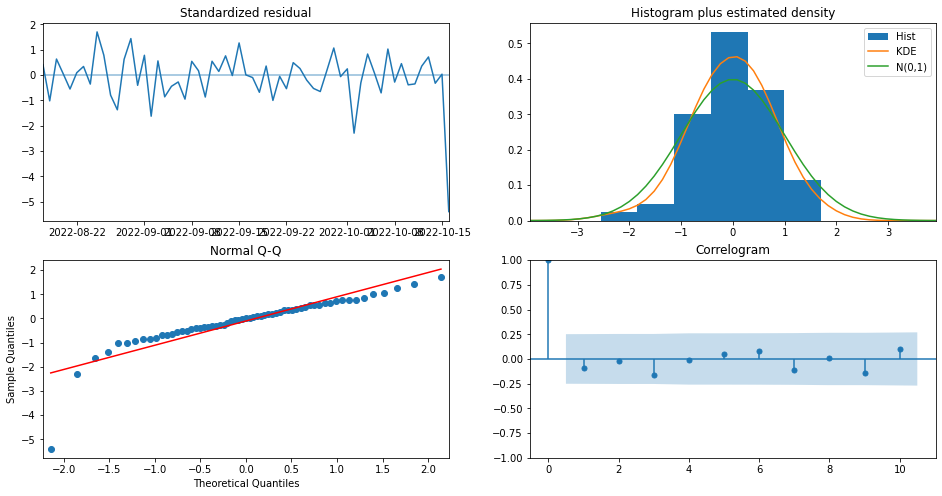

In [46]:

auto_arima_model.plot_diagnostics(figsize=(16,8))
plt.show()

In [47]:
da_predictions = auto_arima_model.predict(31)  #Checking for one month multiple output prediction

In [48]:
da_predictions

2022-10-17 00:00:00+00:00    7650816.0
2022-10-18 00:00:00+00:00    7650816.0
2022-10-19 00:00:00+00:00    7650816.0
2022-10-20 00:00:00+00:00    7650816.0
2022-10-21 00:00:00+00:00    7650816.0
2022-10-22 00:00:00+00:00    7650816.0
2022-10-23 00:00:00+00:00    7650816.0
2022-10-24 00:00:00+00:00    7650816.0
2022-10-25 00:00:00+00:00    7650816.0
2022-10-26 00:00:00+00:00    7650816.0
2022-10-27 00:00:00+00:00    7650816.0
2022-10-28 00:00:00+00:00    7650816.0
2022-10-29 00:00:00+00:00    7650816.0
2022-10-30 00:00:00+00:00    7650816.0
2022-10-31 00:00:00+00:00    7650816.0
2022-11-01 00:00:00+00:00    7650816.0
2022-11-02 00:00:00+00:00    7650816.0
2022-11-03 00:00:00+00:00    7650816.0
2022-11-04 00:00:00+00:00    7650816.0
2022-11-05 00:00:00+00:00    7650816.0
2022-11-06 00:00:00+00:00    7650816.0
2022-11-07 00:00:00+00:00    7650816.0
2022-11-08 00:00:00+00:00    7650816.0
2022-11-09 00:00:00+00:00    7650816.0
2022-11-10 00:00:00+00:00    7650816.0
2022-11-11 00:00:00+00:00

<AxesSubplot: >

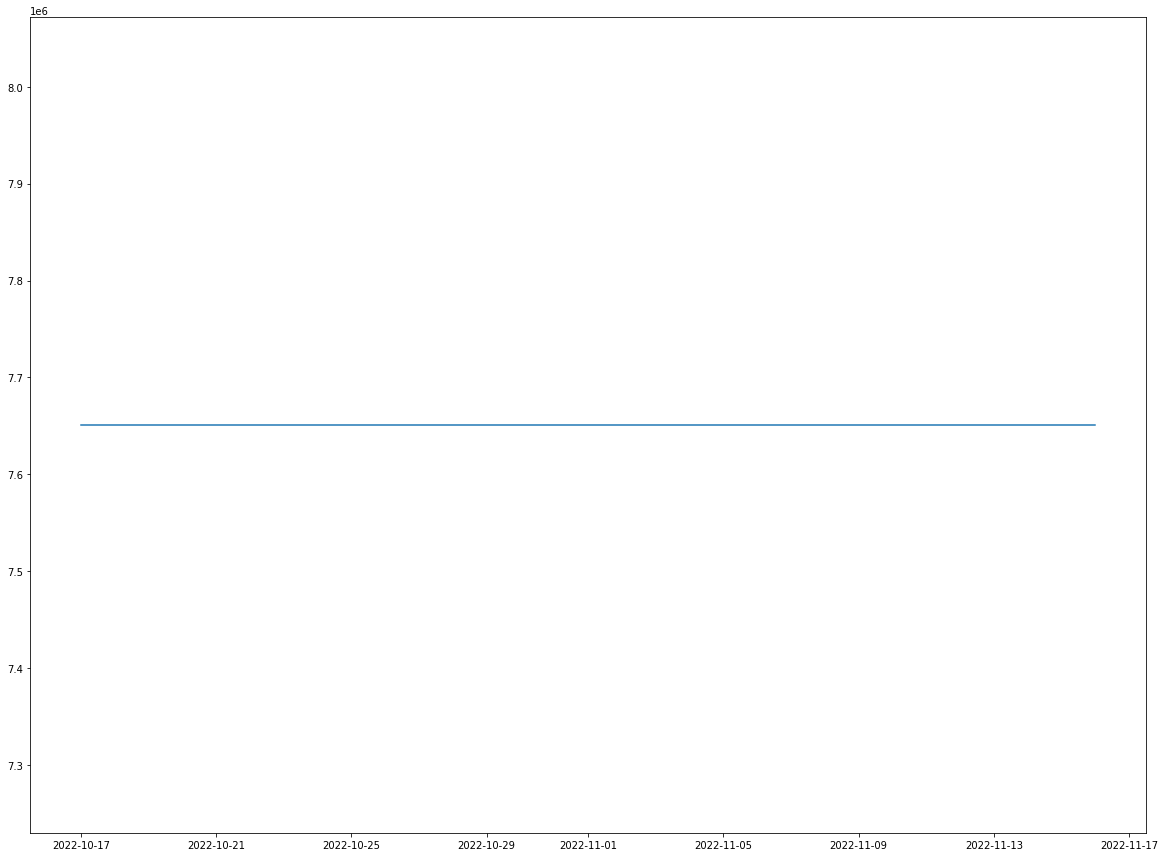

In [49]:
fig, ax = plt.subplots(1,1,figsize=(20,15))
sns.lineplot(data=da_predictions, ax=ax)

# Turns out poor prediction

In [89]:
dayofweek_colors = {
    0:"#41a",
    1:"#13aa45",
    2:"#c2a",
    3:"#97a63a",
    4:"#1fa",
    5:"#67315a",
    6:"#aaa",
    7:"#768",
}

In [51]:
# We count the number of datapoints by day of the week 0 = Monday, 6 = Sunday
joined_df.groupby(joined_df.index.dayofweek).count()[[target_col]].rename(columns={target_col: 'count'})


count
Date       
0       112
1       112
2       112
3       112
4       112
5       112
6       112

In [91]:
viz_df = joined_df.iloc[-150:]

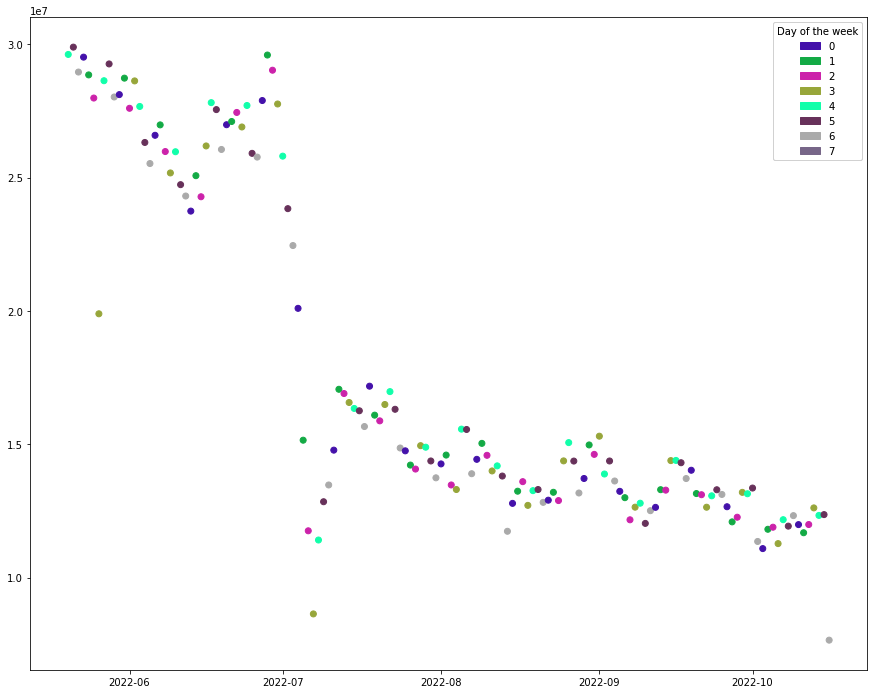

In [92]:
# Plot that shows the historical data by day of the week

plt.close()
fig, ax = plt.subplots(figsize=(15,12))
# ax.scatter(x=viz_df.index,y=viz_df[target_col], c=viz_df.index.dayofweek.map(dayofweek_colors))
ax.scatter(x=viz_df.index,y=viz_df[target_col], c=viz_df.index.dayofweek.map(dayofweek_colors))
handles = [mpatches.Patch(color=v, label=k) for v, k in zip(dayofweek_colors.values(), dayofweek_colors.keys())]
legend = ax.legend(handles=handles,
                   title="Day of the week")
ax.add_artist(legend)
plt.show()


## Trying prophet|

In [54]:
def to_datetimes(uts: list) -> list:
    return [to_datetime(ut) for ut in uts]
def to_datetime(ut) -> datetime.datetime:
    dt = datetime.datetime.utcfromtimestamp(ut)
    ut2 = dt.replace(tzinfo=timezone.utc).timestamp()  # to_unixtime() approach
    assert ut2 == ut, f"ut: {ut}, ut2: {ut2}"
    return dt

In [55]:
prophet_df = joined_df.iloc[-31 * 1:].copy()  # Should use not so long ago data
prophet_df['ds'] = prophet_df.index.tz_localize(None)
prophet_df.rename(columns={target_col:"y"},inplace=True)

In [56]:
prophet_df['ds'].values[-1]

numpy.datetime64('2022-10-16T00:00:00.000000000')

In [57]:
model = Prophet()  #weekly_seasonality=True,  # daily_seasonality=True
model.fit(prophet_df)

16:44:45 - cmdstanpy - INFO - Chain [1] start processing
16:44:45 - cmdstanpy - INFO - Chain [1] done processing


In [93]:
dates = [prophet_df['ds'].values[-1] + pd.Timedelta(x, unit='D') for x in range(1,32 * 2)]
forecast = model.predict(pd.DataFrame({"ds":dates})).set_index('ds')

<AxesSubplot: xlabel='ds', ylabel='yhat'>

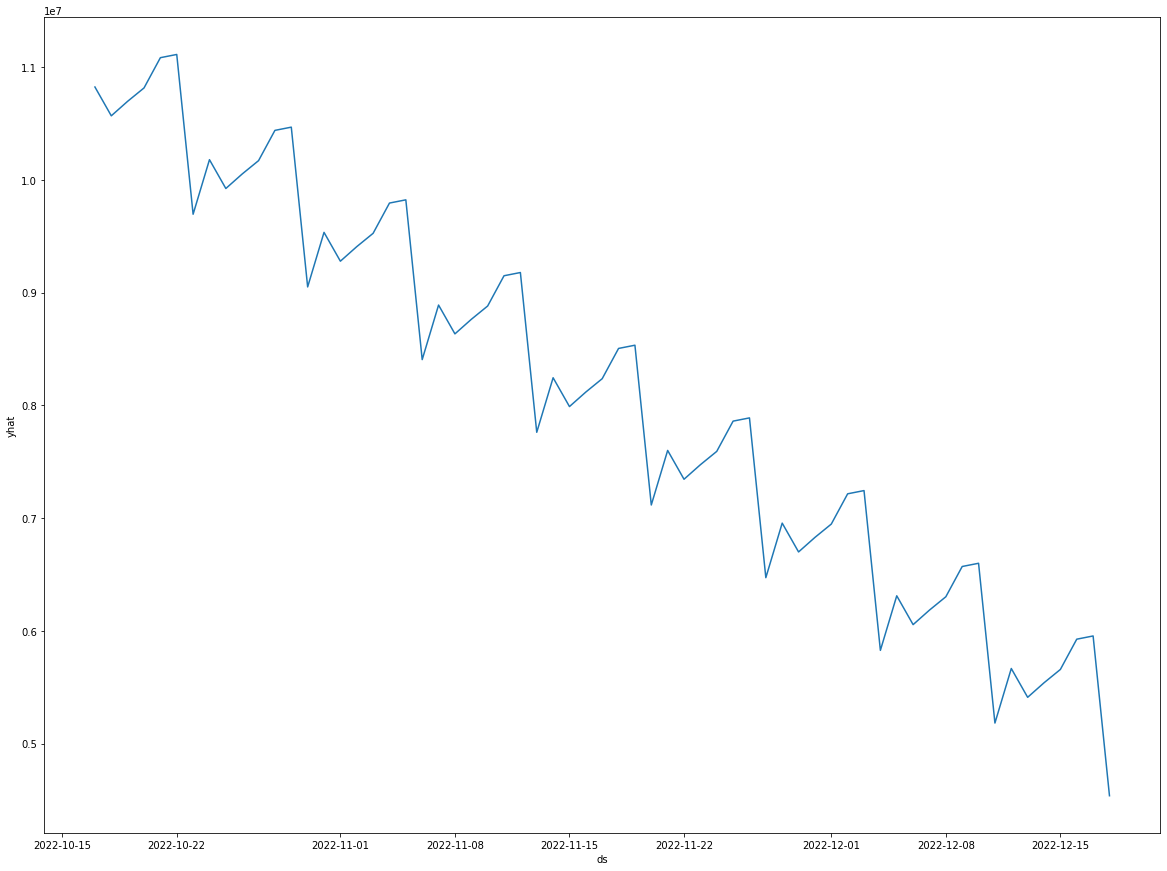

In [94]:
fig, ax = plt.subplots(1,1,figsize=(20,15))
sns.lineplot(data=forecast['yhat'], ax=ax)

### Prophet insights

Prophet is a relatively simple model. It's able to determine the downwards trend when trained on the month of September. 

Accuracy is pretty good because these past 2.5 months have been just following the generic trend of crypto winter + occassional upticks in data storage added likely cuz of swing trading and the price changes affecting data storage added substantially.

## Trying LightGBM

In [108]:
joined_df

Close  Energy used to seal data estimate  \
Date                                                                      
2020-08-24 00:00:00+00:00  22.020189                        3137.985593   
2020-08-25 00:00:00+00:00  22.193523                       21374.515770   
2020-08-26 00:00:00+00:00  21.462585                       20195.466240   
2020-08-27 00:00:00+00:00  22.159378                       21822.785450   
2020-08-28 00:00:00+00:00  24.273489                       24722.329720   
...                              ...                                ...   
2022-10-12 00:00:00+00:00   5.145176                       18322.417960   
2022-10-13 00:00:00+00:00   5.137164                       19275.987600   
2022-10-14 00:00:00+00:00   5.066583                       18845.521530   
2022-10-15 00:00:00+00:00   5.184858                       18891.938110   
2022-10-16 00:00:00+00:00   5.153086                       11694.042730   

                           Data storage capacity added per day  \
Date                                                             
2020-08-24 00:00:00+00:00                              2053024   
2020-08-25 00:00:00+00:00                             13984256   
2020-08-26 00:00:00+00:00                             13212864   
2020-08-27 00:00:00+00:00                             14277536   
2020-08-28 00:00:00+00:00                             16174560   
...                                                        ...   
2022-10-12 00:00:00+00:00                             11987424   
2022-10-13 00:00:00+00:00                             12611296   
2022-10-14 00:00:00+00:00                             12329664   
2022-10-15 00:00:00+00:00                             12360032   
2022-10-16 00:00:00+00:00                              7650816   

                           Energy consumption rate estimate  Close_shift_b_1m  \
Date                                                                            
2020-08-24 00:00:00+00:00                       4929.158175         16.590204   
2020-08-25 00:00:00+00:00                      33604.707650         16.349289   
2020-08-26 00:00:00+00:00                      31820.943110         16.221144   
2020-08-27 00:00:00+00:00                      34445.662720         15.173901   
2020-08-28 00:00:00+00:00                      39074.139640         17.763321   
...                                                     ...               ...   
2022-10-12 00:00:00+00:00                     143347.270200               NaN   
2022-10-13 00:00:00+00:00                     144907.904400               NaN   
2022-10-14 00:00:00+00:00                     144293.880100               NaN   
2022-10-15 00:00:00+00:00                     144430.411500               NaN   
2022-10-16 00:00:00+00:00                     133179.643100               NaN   

                           Close_shift_b_2m  Close_shift_b_3m  \
Date                                                            
2020-08-24 00:00:00+00:00         38.494858         30.973227   
2020-08-25 00:00:00+00:00         33.722610         29.928549   
2020-08-26 00:00:00+00:00         35.245758         29.921663   
2020-08-27 00:00:00+00:00         33.615265         29.986433   
2020-08-28 00:00:00+00:00         32.643192         30.012173   
...                                     ...               ...   
2022-10-12 00:00:00+00:00               NaN               NaN   
2022-10-13 00:00:00+00:00               NaN               NaN   
2022-10-14 00:00:00+00:00               NaN               NaN   
2022-10-15 00:00:00+00:00               NaN               NaN   
2022-10-16 00:00:00+00:00               NaN               NaN   

                           Close_shift_b_4m  Close_shift_b_5m  
Date                                                           
2020-08-24 00:00:00+00:00         23.564009         22.191210  
2020-08-25 00:00:00+00:00         22.268867         21.462456  
2020-08-26 00:00:00+00:00         22.013

## Try LSTM and others with scalecast

In [134]:
sample_df = joined_df.iloc[-31 * 3:]

In [135]:


f = Forecaster(y=sample_df[target_col],current_dates=[d.date() for d in sample_df.index.to_numpy()])



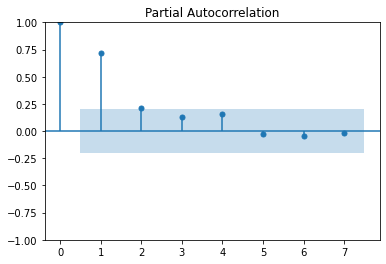

In [136]:
f.plot_pacf(lags=7)
plt.show()

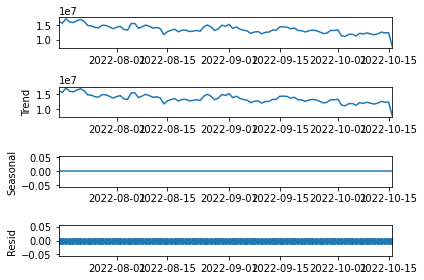

In [137]:
f.seasonal_decompose (model='additive', extrapolate_trend='freq', period=1).plot()
plt.show()

In [138]:
stat, p, _, _, _, _ = f.adf_test(full_res=True)
print( stat,p)


-0.09398524137763284 0.95003434107373


In [141]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html, test whether a sample differs from a normal distribution
f.normality_test()

NormaltestResult(statistic=8.507416074504983, pvalue=0.01421143954052046)

In [139]:


f.set_test_length(30)     
f.generate_future_dates(90)
f.set_estimator('lstm')



1/1 [==============================] - 0s 9ms/step


''

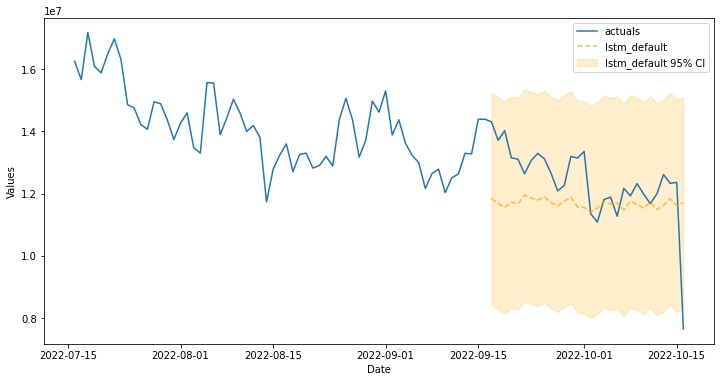

In [140]:


f.manual_forecast(call_me='lstm_default')
f.plot_test_set(ci=True)

""

In [151]:
#https://github.com/mikekeith52/scalecast
from scalecast.Pipeline import Pipeline, Transformer, Reverter
from scalecast.auxmodels import mlp_stack
from scalecast import GridGenerator

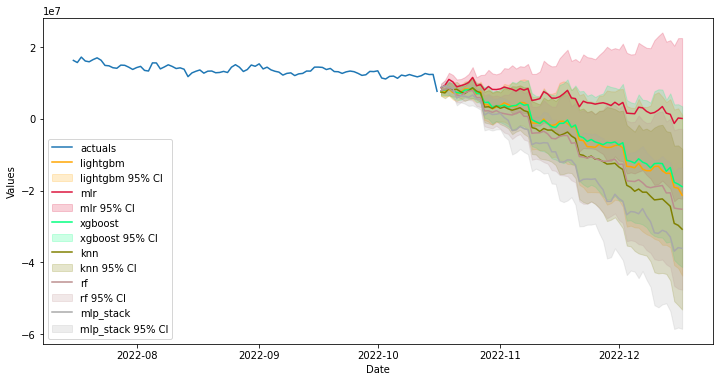

In [170]:

models = (
    'rf',
    'mlr',
    'knn',
#     'prophet',
#     'elasticnet'
    'lightgbm',
    'xgboost'
)

# models = (
#     'arima',
#   'mlr',
#   'elasticnet',
#   'lightgbm',
#   'knn',
#     'prophet',
#     'rf')

f = Forecaster(y=sample_df[target_col],current_dates=[d.date() for d in sample_df.index.to_numpy()],
  future_dates=31 * 2)


f.set_test_length(.2)
f.set_validation_length(24)

def forecaster(f,models):
    """ add Xvars and forecast
    """
#     f.add_covid19_regressor()
    f.auto_Xvar_select()
    f.tune_test_forecast(
        models,
        dynamic_testing=24, # test-set metrics will be an average of rolling 24-step forecasts
        cross_validate=True,
        k = 3,
    )
    mlp_stack(f,models)
    
transformer = Transformer(
    transformers = [
        ('DiffTransform',1),
        ('DiffTransform',12),
    ],
)
reverter = Reverter(
    # list reverters in reverse order
    reverters = [
        ('DiffRevert',12),
        ('DiffRevert',1),
    ],
    base_transformer = transformer,
)
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ],
)

f = pipeline.fit_predict(f,models=models)

f.reeval_cis() # expanding cis based on all model results
f.plot(ci=True,order_by='LevelTestSetMAPE')
plt.show()

results = f.export(
  ['model_summaries','lvl_fcsts']
)

### Delving deeper into price correlation

Aside from FILcoin close prices being relatively highly correlated with data store added, it's possible to be correlated with other crypto currencies, which in turn may be affected by traditional markets. Let's investigate other crpyto currencies first

In [95]:
filusd = filusd.set_index('Date')

In [96]:
filusd

Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2017-12-13  11.474800  11.507300  11.018800  11.503200  11.503200     296217
2017-12-14  11.483200  11.804200  10.954300  11.481600  11.481600     391397
2017-12-15  11.480900  13.001400  11.152600  12.900500  12.900500     653202
2017-12-16  12.900500  21.955000  12.870500  20.495501  20.495501    2137330
2017-12-17  20.502399  20.502399  17.840700  19.435400  19.435400     624487
...               ...        ...        ...        ...        ...        ...
2022-11-13   4.268186   4.429925   4.222209   4.293976   4.293976  119578514
2022-11-14   4.294374   4.389970   4.106500   4.316591   4.316591  161268566
2022-11-15   4.316776   4.491105   4.292059   4.389140   4.389140  114251131
2022-11-16   4.388834   4.534030   4.274555   4.337914   4.337914  147278408
2022-11-17   4.334792   4.383778   4.262553   4.285855   4.285855  130081440

[1801 rows x 6 columns]

<AxesSubplot: xlabel='Date', ylabel='Open'>

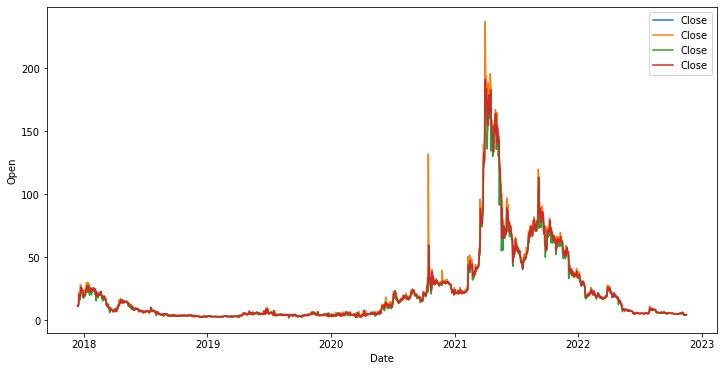

In [97]:
fig, ax = plt.subplots(figsize=(12, 6))
# sns.lineplot(data=filusd, label = 'Prices', ax=ax)
sns.lineplot(data=filusd, x="Date", y="Open", label = 'Close', ax=ax)
sns.lineplot(data=filusd, x="Date", y="High", label = 'Close', ax=ax)
sns.lineplot(data=filusd, x="Date", y="Low", label = 'Close', ax=ax)
sns.lineplot(data=filusd, x="Date", y="Open", label = 'Close', ax=ax)


In [98]:
# df = filusd.iloc[-100:-1]
df = filusd.iloc[-2500:-1].rolling(
    window=31,       # 31-day window
    center=True,      # puts the average at the center of the window
    min_periods=16,  # choose about half the window size
).mean()   

In [99]:
df.head()

Open       High        Low      Close  Adj Close  \
Date                                                                
2017-12-13  19.705588  21.725494  17.870138  20.397494  20.397494   
2017-12-14  19.818577  21.753841  17.973065  20.375365  20.375365   
2017-12-15  19.817095  21.677344  17.941584  20.283083  20.283083   
2017-12-16  19.762084  21.599847  17.937753  20.272300  20.272300   
2017-12-17  19.763335  21.546730  17.961505  20.232695  20.232695   

                   Volume  
Date                       
2017-12-13  729469.000000  
2017-12-14  707095.823529  
2017-12-15  679342.277778  
2017-12-16  650241.157895  
2017-12-17  627513.100000

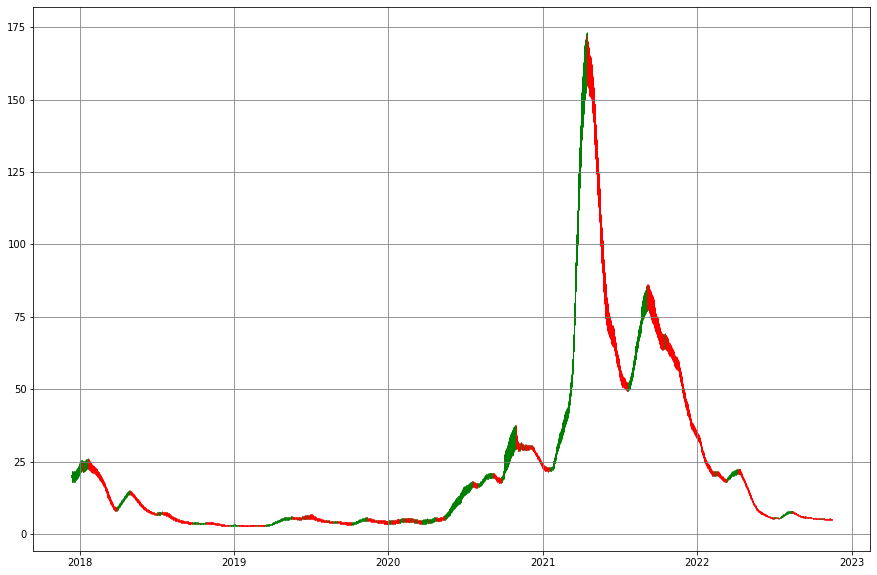

In [100]:
# https://levelup.gitconnected.com/creating-candlestick-plots-for-stocks-50c35b1573aa
width  = 0.9   # width of real body
width2 = 0.05  # width of shadow
fig, ax = plt.subplots(figsize=(15,10))
# find the rows that are bullish
dfup = df[df.Close >= df.Open]
# find the rows that are bearish
dfdown = df[df.Close < df.Open]
# plot the bullish candle stick
ax.bar(dfup.index, dfup.Close - dfup.Open, width, 
       bottom = dfup.Open, edgecolor='g', color='green')
ax.bar(dfup.index, dfup.High - dfup.Close, width2, 
       bottom = dfup.Close, edgecolor='g', color='green')
ax.bar(dfup.index, dfup.Low - dfup.Open, width2, 
       bottom = dfup.Open, edgecolor='g', color='green')
# plot the bearish candle stick
ax.bar(dfdown.index, dfdown.Close - dfdown.Open, width, 
       bottom = dfdown.Open, edgecolor='r', color='red')
ax.bar(dfdown.index, dfdown.High - dfdown.Open, width2, 
       bottom = dfdown.Open, edgecolor='r', color='red')
ax.bar(dfdown.index, dfdown.Low - dfdown.Close, width2, 
       bottom = dfdown.Close, edgecolor='r', color='red')
ax.grid(color='gray')

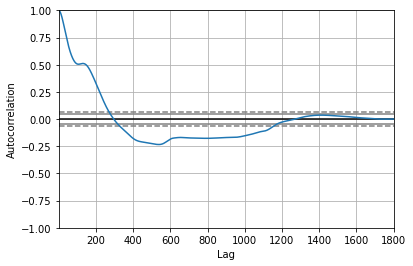

In [101]:
# Look for any auto correlations
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['Close'])
plt.show()

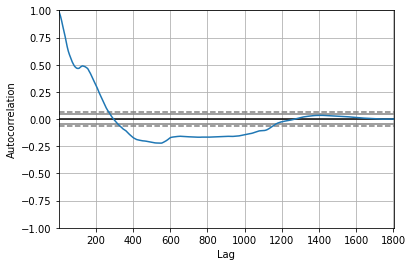

In [102]:
autocorrelation_plot(filusd['Close'])
plt.show()


/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


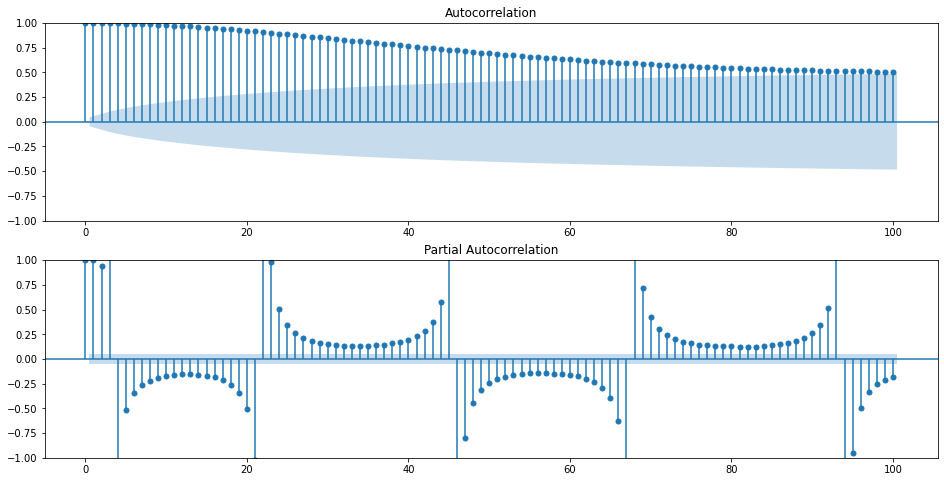

In [103]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['Close'], lags=100, ax=ax[0])
plot_pacf(df['Close'], lags=100, ax=ax[1])

plt.show()

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


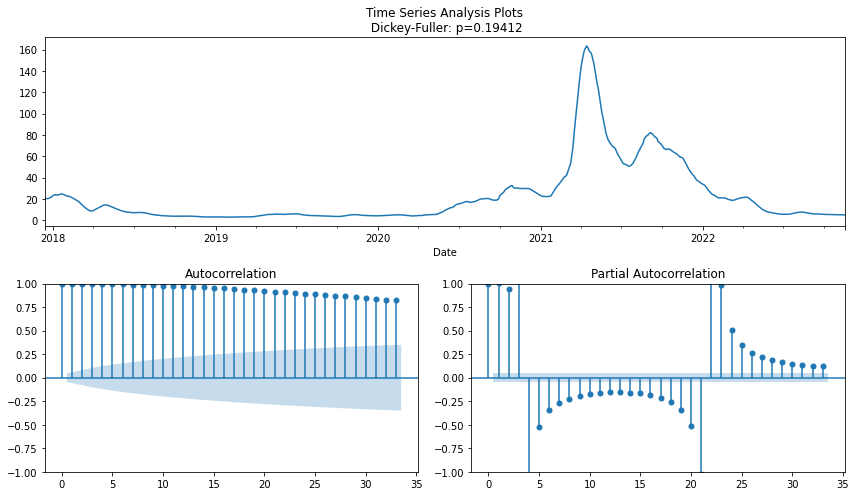

In [104]:
tsplot(df['Close'])

## Some of the models we use depend on linearity of the data. Currently this data is non-stationary and hence either we make it stationary, or using a non-linear model

## Find and publish on Ocean Market a dataset on the energy consumption of conventional data center storage. Then, compare the energy performance of Filecoin storage to that of conventional data centers. What can you conclude?

Most data found are PUE data, this may be sufficient to show energy efficiency in storing data relative to the other energy consumption to maintain the infra for this service

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=consumption, x="Date", y="Energy consumption rate estimate", label = 'Added', ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=consumption, x="Date", y="PUE", label = 'PUE', ax=ax)
plt.show()

## PUE somehow is at a constant of 1.57 across the 2 years

Based on google data center statistics, 
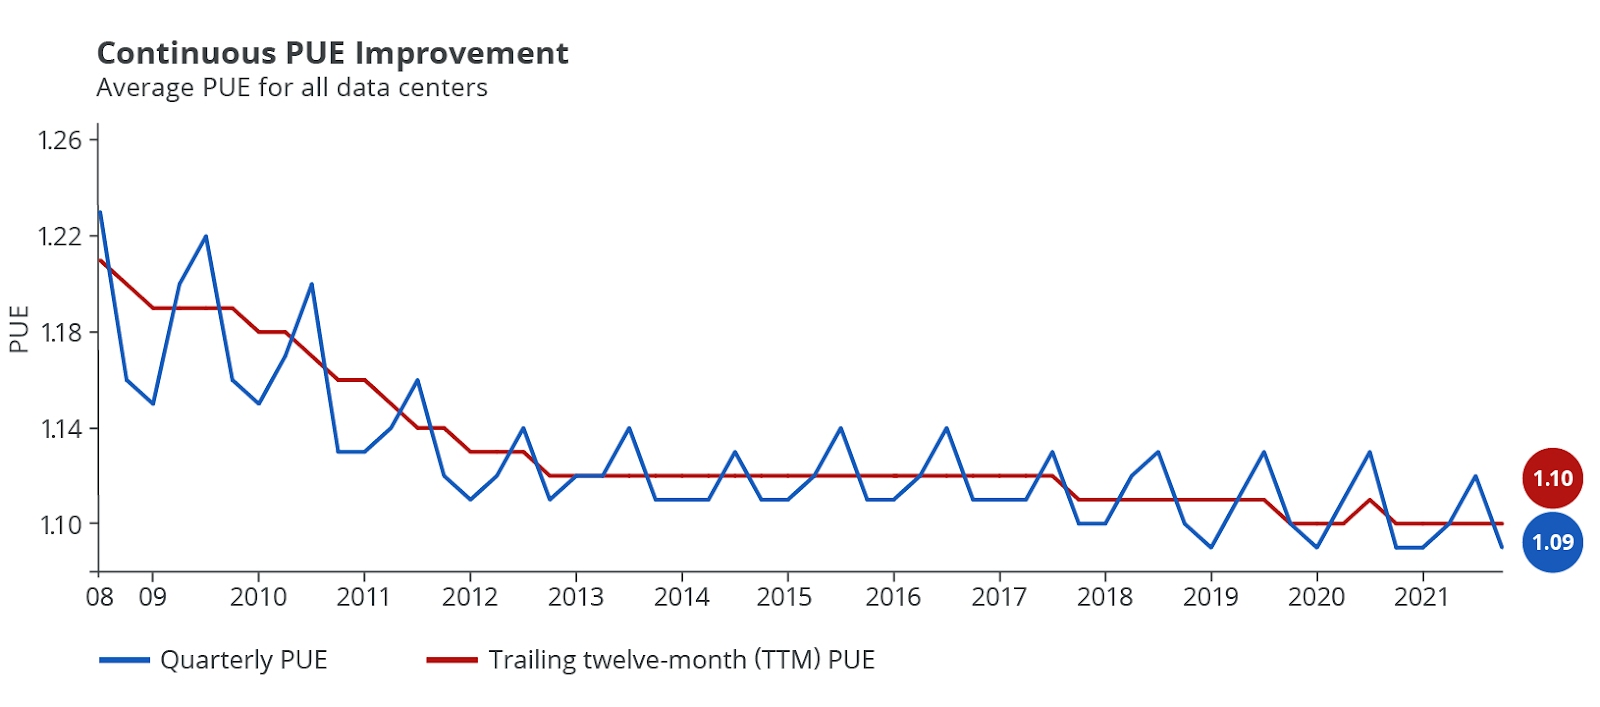

And global PUE data from statistica
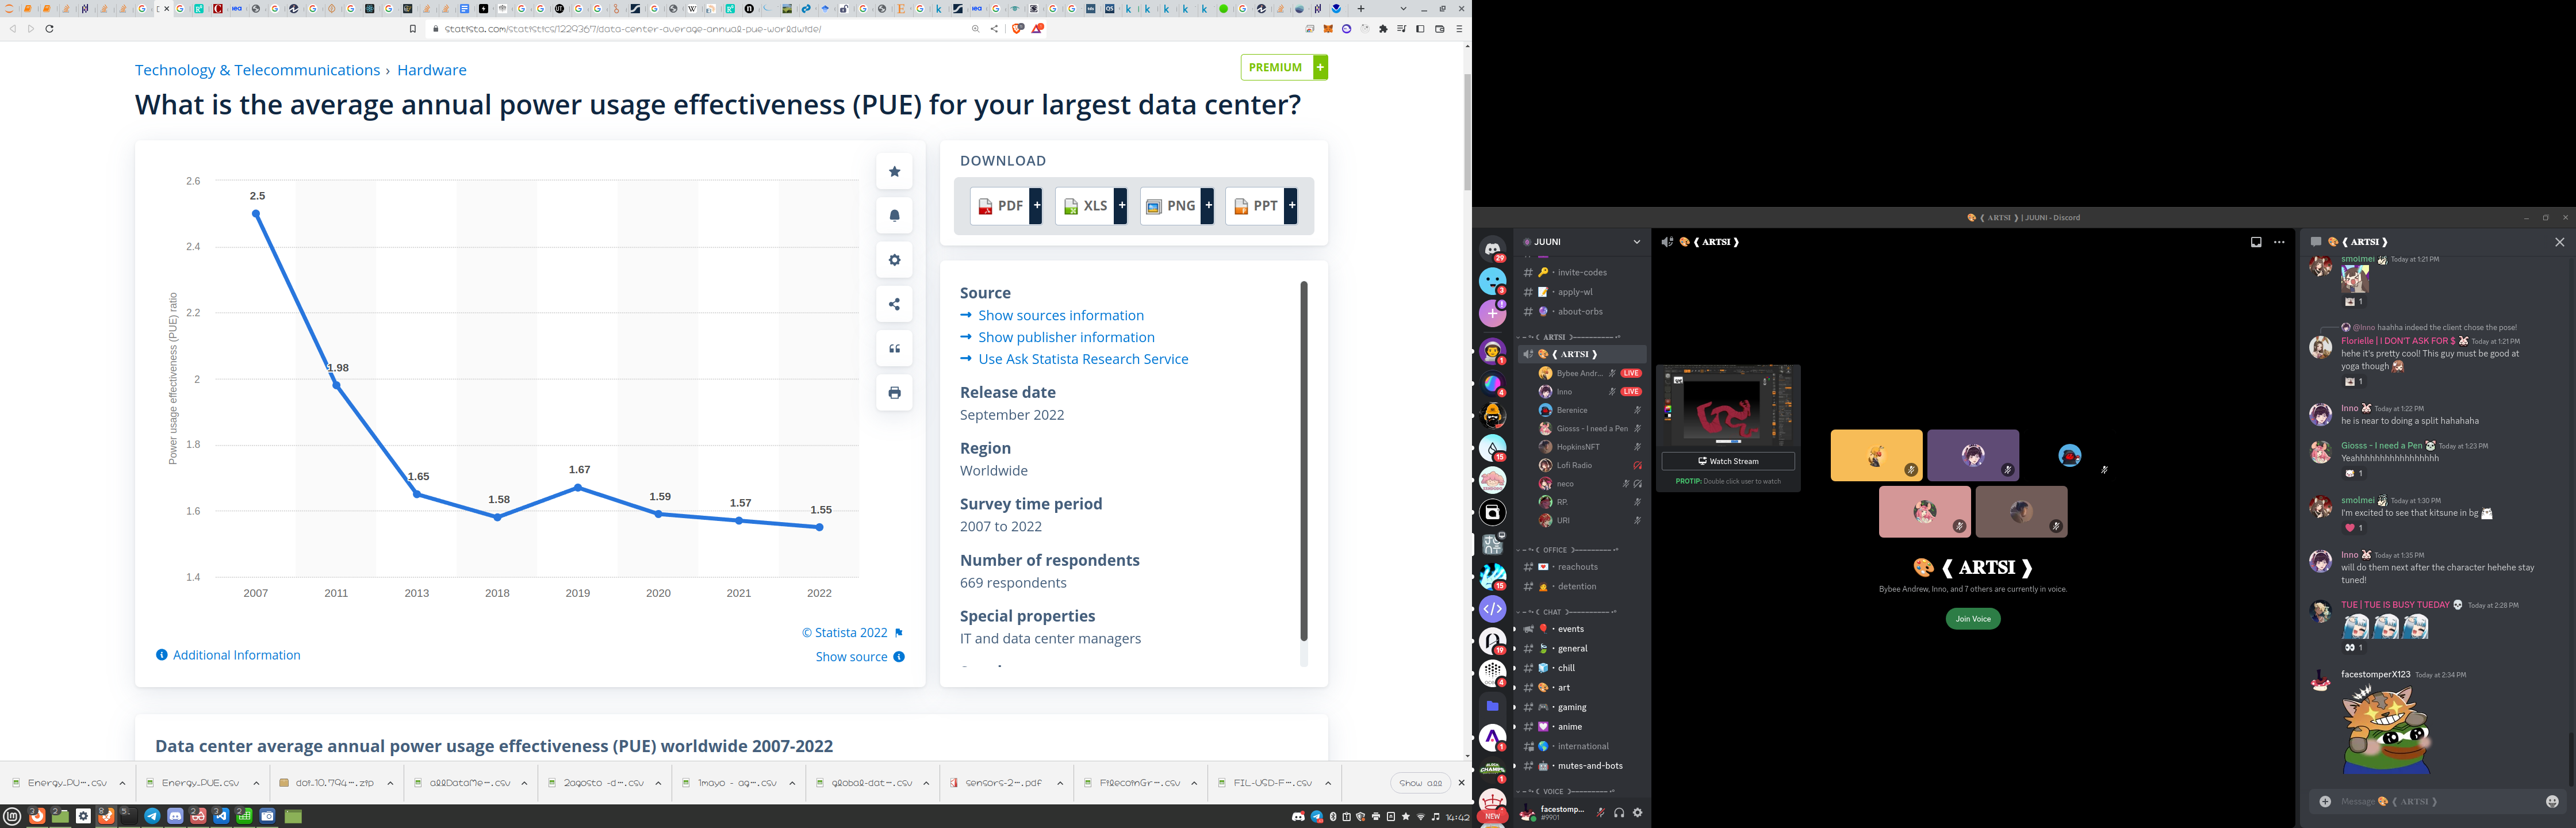


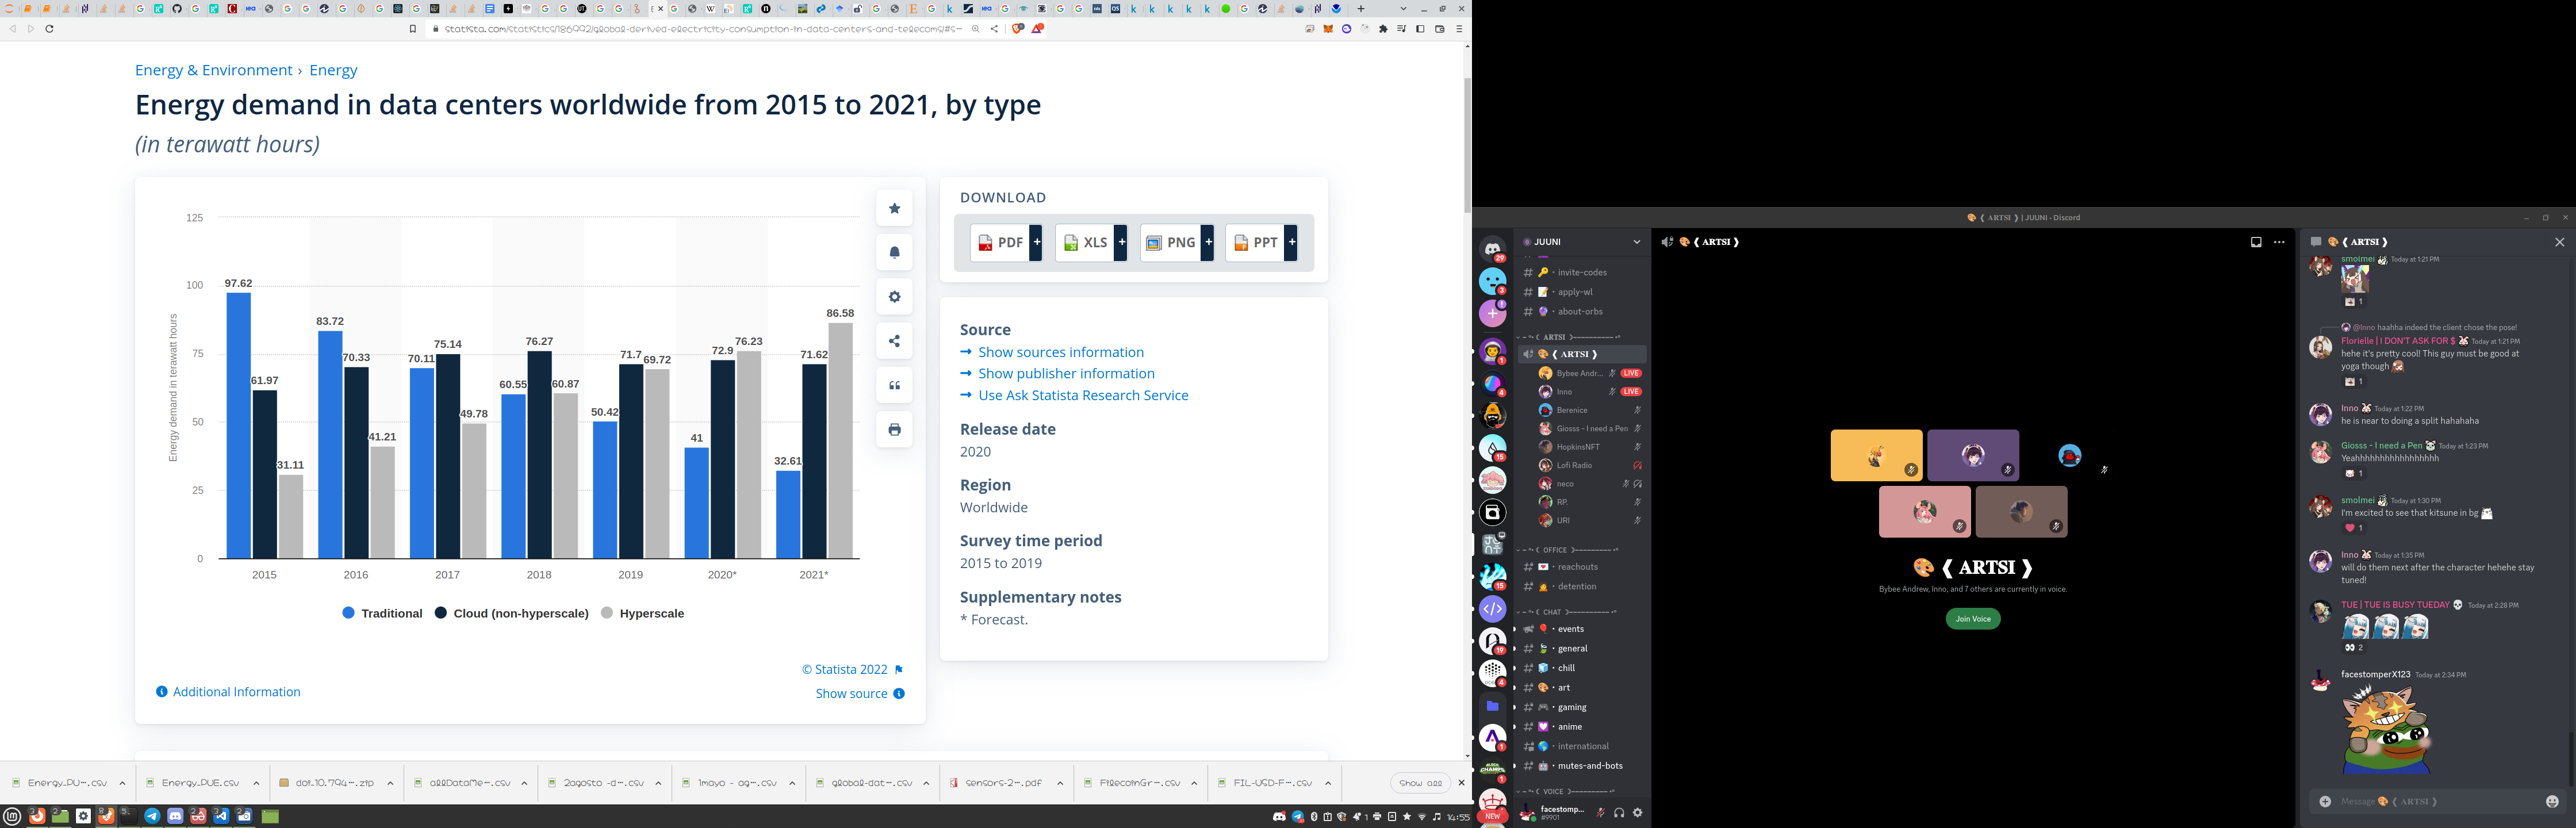

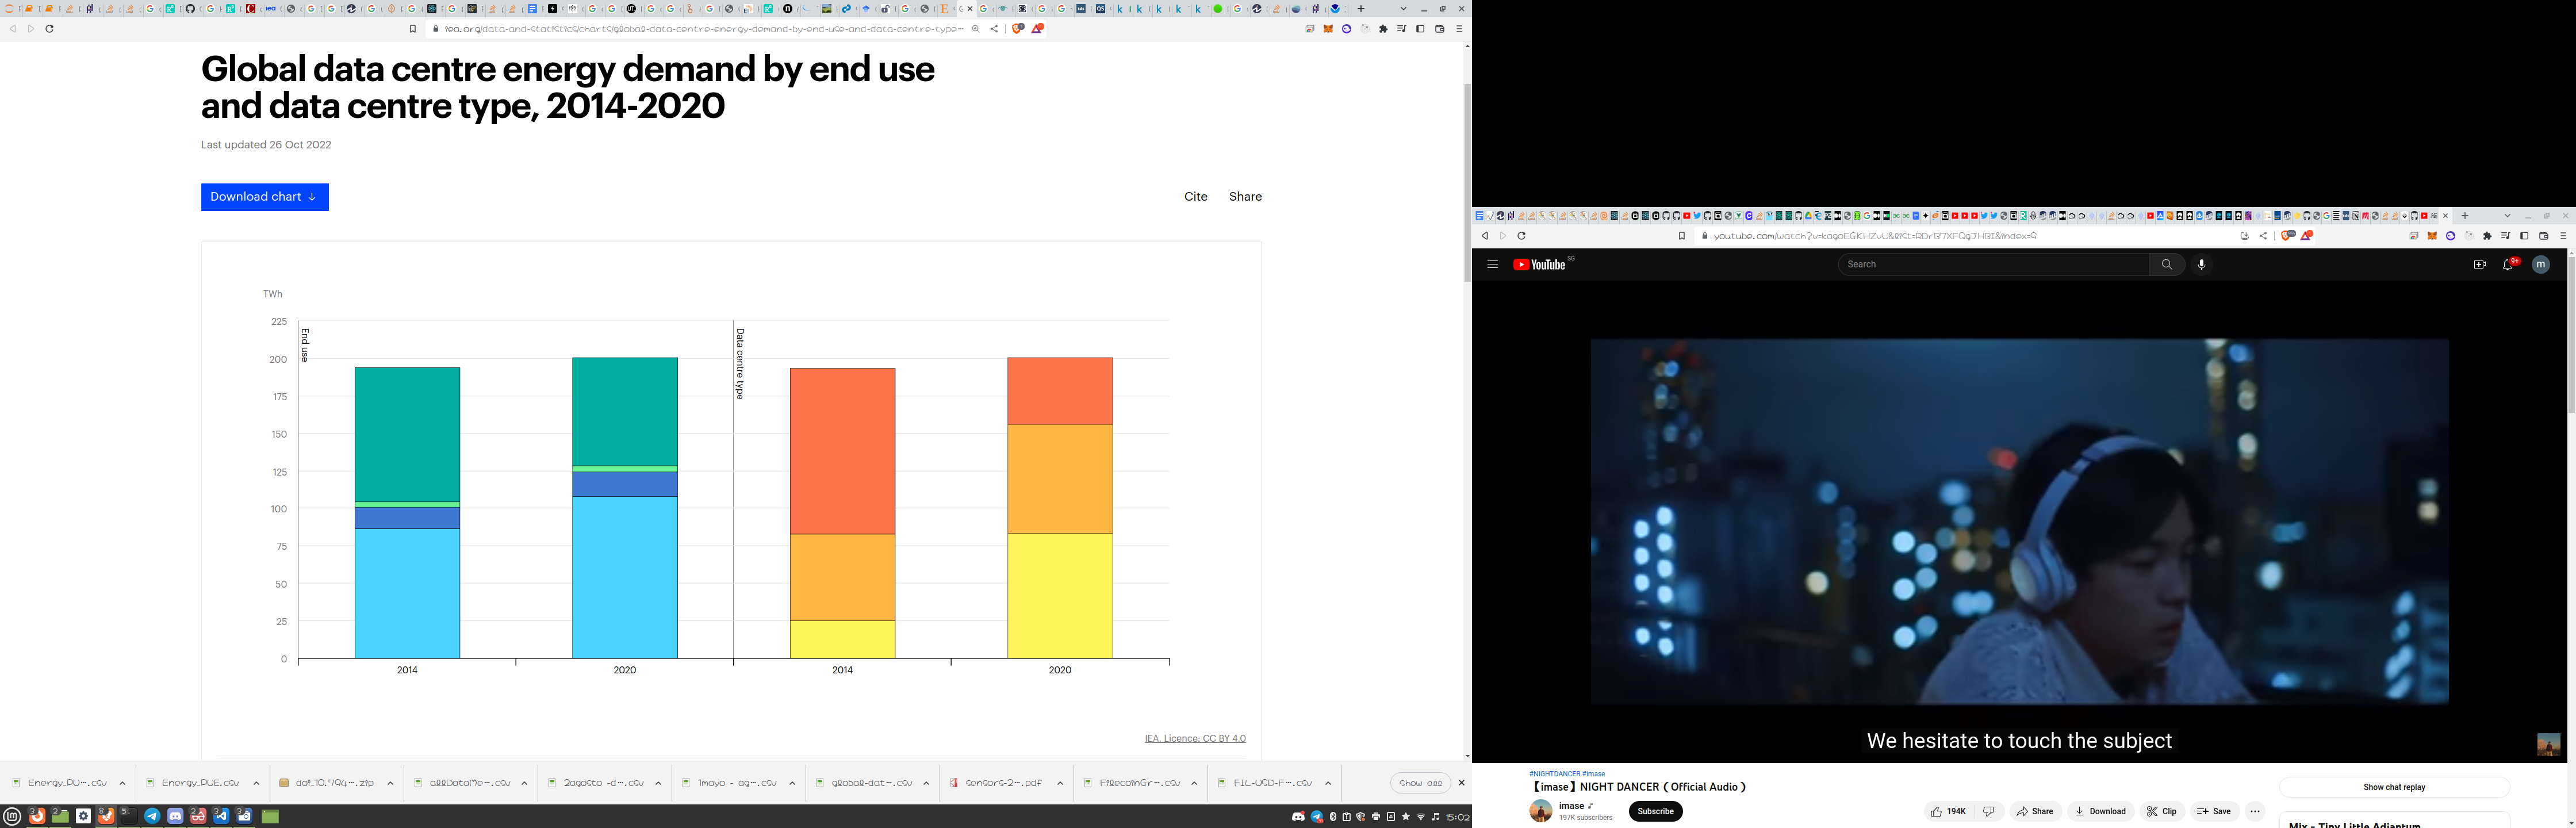


Since PUE is constant, and according to the Uptime Institute's 2021 Data Center Survey, the global average of respondents' largest data centers is around 1.57, PUE is likely just taken from this.

<!-- PUE is on par with that of conventional data centers in recent times, which may mean data storage added in recent times are either from many individual data providers (where non IT electricity used is insignificant) and/or from hyperscale data centers -->

## Energy consumption wise

Based on Cumulative energy use estimates over the past 2 years, FIL uses about 1 TWh of energy cumlative since 2020, whereas per year global data centers use about 200 TWh of energy. 



## Proportion of data stored

https://www.statista.com/statistics/871513/worldwide-data-created/

2010 - 2020, forcast 2021-2025

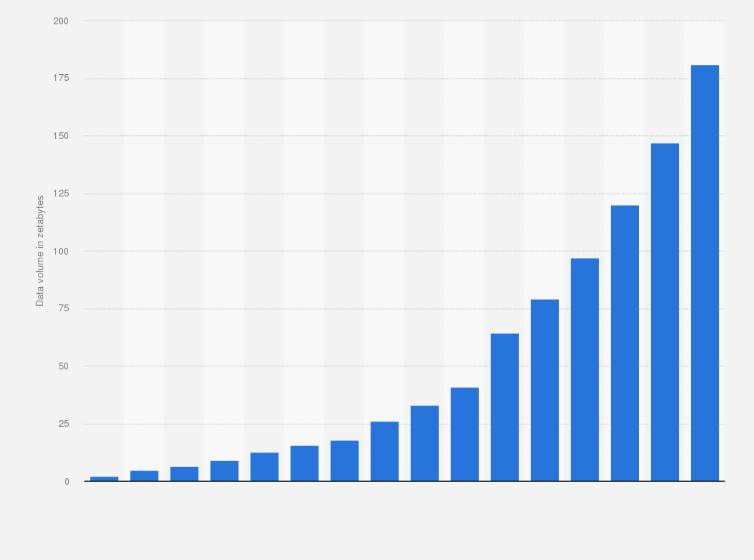

So far filecoin stores about 20 billion GBs of data, while other conventional data centers stores 65 trillion GBs of data in 2020, which is about 3000 times more. 

Thus, energy performance wise is about 200/3000 times that of conventional data centers.


In [ ]:
air_cool_df = pd.read_csv("Air Free-Cooled Data Center/Energy_PUE.csv", parse_dates = ['Timestamp'])

In [ ]:
air_cool_df = air_cool_df.set_index('Timestamp')

In [ ]:
air_cool_df.head()

In [ ]:
air_cool_df.describe()

In [ ]:
np.mean(air_cool_df.index.groupby(np.arange(len(air_cool_df))//5), axis=1)

In [ ]:

# mean_air_cool_df = air_cool_df.groupby(np.arange(len(air_cool_df))//5).mean()
mean_air_cool_df = air_cool_df.resample('60min').mean()  #60min  10T

In [ ]:
mean_air_cool_df.head()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=mean_air_cool_df, x="Timestamp", y="PUE", label = 'PUE', ax=ax)
plt.show()

In [ ]:
ecuador_df = pd.read_csv("allDataMean.csv")

In [ ]:
ecuador_df.head()

## Refs

https://energyinnovation.org/2020/03/17/how-much-energy-do-data-centers-really-use/

https://davidmytton.blog/how-much-energy-do-data-centers-use/

https://en.wikipedia.org/wiki/Power_usage_effectiveness

https://www.nature.com/articles/s41597-022-01257-x#Sec13

https://www.statista.com/statistics/1229367/data-center-average-annual-pue-worldwide/

https://www.statista.com/statistics/186992/global-derived-electricity-consumption-in-data-centers-and-telecoms/#statisticContainer

https://www.iea.org/data-and-statistics/charts/global-data-centre-energy-demand-by-data-centre-type-2010-2022